## Evaluation of UTOPIA's performance in predicting MPs size dristributionsusing the monaco Monte Carlo framework 
#### (https://monaco.readthedocs.io/en/latest/)

With this script we preform an evaluation of UTOPIA's size distribution predictive capacity by comparing predicted size distributions in targeted compartmanes aginst observed MPs size distributions reported in the compilation of published datasets by Kooi et al.

### Import the necessary libraries

In [1]:
from utopia.monte_carlo.montecarlo_analysis_paper import run_mc_analysis_paper, set_emission, sim_to_dataframe, reshape_mc_results
from utopia.monte_carlo.monte_carlo_helpers import *
from utopia.utopia import utopiaModel
import numpy as np
import scipy.stats as st
import pandas as pd

c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\monaco\dvars_sensitivity.py:18: UserWarning: Consider installing numba for better performance
  warn("Consider installing numba for better performance", UserWarning)


### Load the UTOPIA's default configuration parameters 

In [2]:
data_data = utopiaModel.load_json_file("data/default_data.json")
config_data = utopiaModel.load_json_file("data/default_config.json")


### Define the parameter distributions for the Monte Carlo simulation.


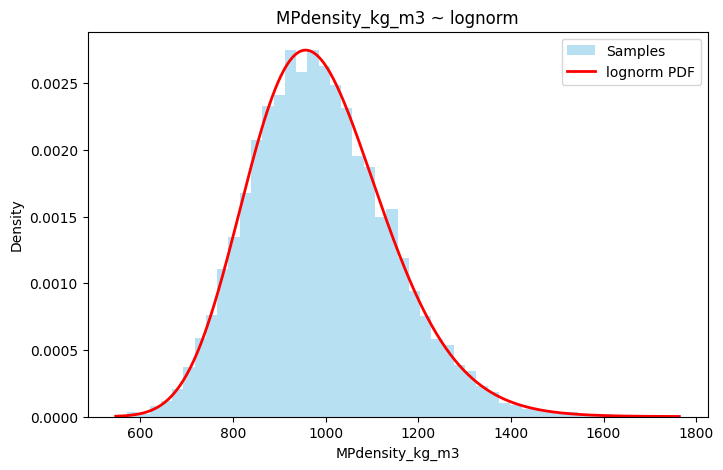

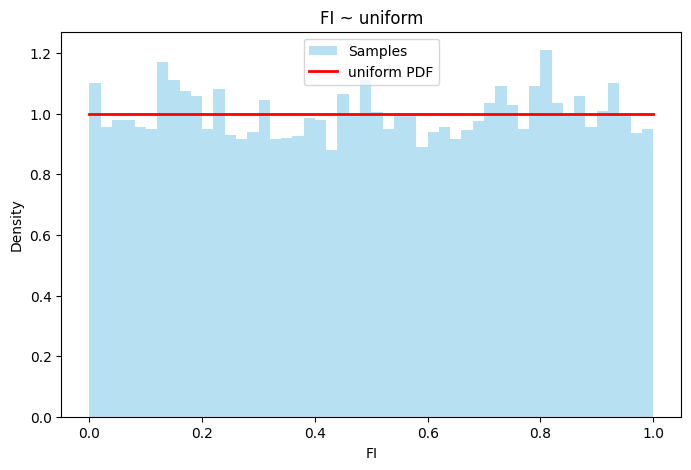

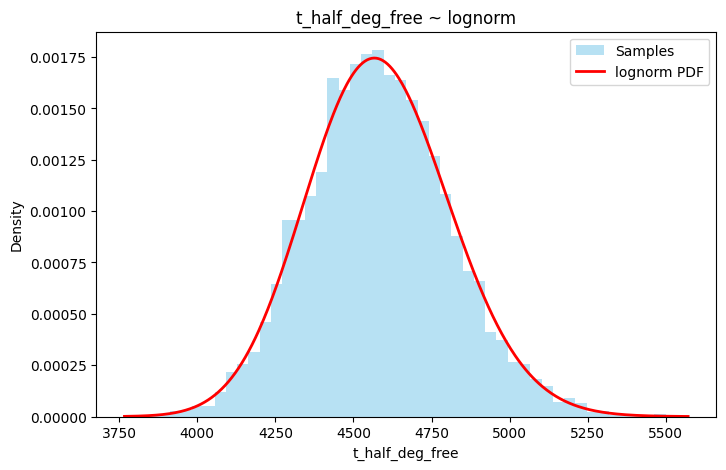

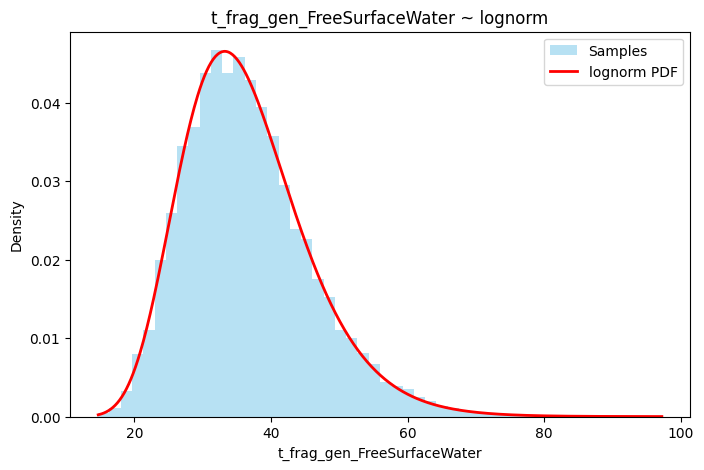

In [3]:
# Define the parameters that you want to sample from the input parameters included on the data loaded from the default data file and select a distribution for each parameter.
param_distributions = {
    "MPdensity_kg_m3": ("lognorm", {"s": 0.15, "scale": np.exp(np.log(data_data["MPdensity_kg_m3"]) - (0.05**2) / 2)}),
    "FI": ("uniform", {"loc": 0.0, "scale": 1.0}),
    "t_half_deg_free": ("lognorm", {"s": 0.05, "scale": np.exp(np.log(data_data["t_half_deg_free"]) - (0.05**2) / 2)}),
    "t_frag_gen_FreeSurfaceWater": ("lognorm", {"s": 0.25, "scale": np.exp(np.log(data_data["t_frag_gen_FreeSurfaceWater"]) - (0.25**2) / 2)})
}

for psrsm in param_distributions:
    plot_distribution_from_dict(psrsm, param_distributions)

In [4]:
# Set emission scenarios to run that are compatible for comparison with observations data from Kooi et al.

##############################################
# DEFINE ARTICLE -> EMISSION SCENARIOS
##############################################

overlay_emission_scenarios = {
    "Sea Sediment | Bergmann":["Ocean_Surface_Water","Coast_Surface_Water","Coast_Column_Water"],
    "Sea Surface all | Cai":["Surface_Freshwater","Coast_Surface_Water","Impacted_Soil_Surface"],
    "Sea Surface Fragments | Enders":["Ocean_Surface_Water","Coast_Surface_Water"],
    "Sea Surface Fibers | Enders":["Ocean_Surface_Water","Coast_Surface_Water"],
    "Fragments in water | Eo":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Fibers in water | Eo":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Fragments in sediment | Eo":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Fibers in sediment | Eo":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Sea Surface all | Erni-Cassola":["Coast_Surface_Water","Impacted_Soil_Surface"],
    "Fresh water sediments | Imhof":["Surface_Freshwater","Impacted_Soil_Surface"],
    "Sea Surface all | Isobe L1":["Surface_Freshwater","Coast_Surface_Water"],
    "Sea Surface all | Isobe L2":["Surface_Freshwater","Coast_Surface_Water"],
    "Sea Surface all | Isobe L3":["Surface_Freshwater","Coast_Surface_Water"],
    "Sea Surface all | Isobe L4":["Surface_Freshwater","Coast_Surface_Water"],
    "FP all | Scheurer":["Impacted_Soil_Surface"],
    "Sea Surface Fragments | Song":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Sea Surface Fibers | Song":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Sea Surface all | Zhang":["Coast_Surface_Water","Surface_Freshwater"]}
    
    
    
    
# DEFINE ARTICLE->COMPARTMENTS MAPPING
#############################################
overlay_compartments_mapping = {
    "Sea Sediment | Bergmann": ["Sediment_Coast", "Sediment_Ocean"],
    "Sea Surface all | Cai": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface Fragments | Enders": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface Fibers | Enders": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Fragments in water | Eo": ["Bulk_Freshwater", "Surface_Freshwater"],
    "Fibers in water | Eo": ["Bulk_Freshwater", "Surface_Freshwater"],
    "Fragments in sediment | Eo": ["Sediment_Ocean", "Sediment_Coast", "Beaches_Deep_Soil","Beaches_Soil_Surface", "Sediment_Freshwater"],
    "Fibers in sediment | Eo": ["Sediment_Ocean", "Sediment_Coast", "Beaches_Deep_Soil",
    "Beaches_Soil_Surface", "Sediment_Freshwater"],
    "Sea Surface all | Erni-Cassola": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Fresh water sediments | Imhof": ["Bulk_Freshwater", "Surface_Freshwater"],
    "Sea Surface all | Isobe L1": ["Coast_Surface_Water", "Ocean_Surface_Water"], 
    "Sea Surface all | Isobe L2": ["Coast_Surface_Water", "Ocean_Surface_Water"], 
    "Sea Surface all | Isobe L3": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface all | Isobe L4": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "FP all | Scheurer": ["Coast_Surface_Water", "Ocean_Surface_Water"], 
    "Sea Surface Fragments | Song": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface Fibers | Song": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface all | Zhang": ["Coast_Surface_Water", "Ocean_Surface_Water"]
}

# NOTE! Maybe the mapping for the FP all | Scheurer study has to be revisited. Samples were collected in floodplain soils, so the impacted_soil_surface compartment might be more appropriate. Since the model does not simulate floodplain soils as a separate compartment.?

In [5]:
# Set emission scenarios according to the mapping defined above to the run the model for each parameter combination using the Monte Carlo framework and perform the comparison with the observed data according to mapping.

In [6]:
# Run the Monte Carlo analysis with the specified parameters distributions and number of cases for specified emission scenarios related to the obsserved data from articles in the list.

all_results = [] 

# Run the Monte Carlo analysis for each article and emission scenario
for art in overlay_emission_scenarios: 
    for comp in overlay_emission_scenarios[art]:
        # Set emissions to that compartment and include it in base_data file
        data_data["emiss_dict_g_s"]= set_emission(data_data["emiss_dict_g_s"].copy(), comp, "e", 100)
        # Run Monte Carlo analysis for each emission scenario
        sim= run_mc_analysis_paper(
        base_config=config_data,
        base_data=data_data,
        param_distributions=param_distributions,
        n_cases=20,art=art,
    )
        # Convert sim results to dataframe
        df_MC_results = sim_to_dataframe(sim)
        
        #Transform dataframe to long format for easier processing
        input_params=["MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater","residence_time_mass","residence_time_number","persistence_mass","persistence_number"]
        compartments= overlay_compartments_mapping[art]
        dataset_name=art
        emission_comp=comp
        tidy=reshape_mc_results(df_MC_results, compartments, input_params, dataset_name, emission_comp)
        
        all_results.append(tidy)

results_df = pd.concat(all_results, ignore_index=True)

Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done


Running cases:   5%|▌         | 1/20 [00:02<00:53,  2.83s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  10%|█         | 2/20 [00:05<00:48,  2.71s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kw

Simulation complete! Runtime: 0:00:46.308166
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   5%|▌         | 1/20 [00:02<00:43,  2.30s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  10%|█         | 2/20 [00:04<00:39,  2.20s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **k

Simulation complete! Runtime: 0:00:44.934944
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   5%|▌         | 1/20 [00:02<00:41,  2.19s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  10%|█         | 2/20 [00:04<00:38,  2.15s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **k

Simulation complete! Runtime: 0:00:44.969707
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 3628.45 cases/s]

Simulation complete! Runtime: 0:00:44.585560
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:43.884557
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 3068.48 cases/s]

Simulation complete! Runtime: 0:00:45.003448
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 1094.90 cases/s]

Simulation complete! Runtime: 0:00:44.714544
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 1640.32 cases/s]

Simulation complete! Runtime: 0:00:40.983536
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 3670.84 cases/s]

Simulation complete! Runtime: 0:00:42.963591
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 2632.63 cases/s]

Simulation complete! Runtime: 0:00:45.645199
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 2499.88 cases/s]

Simulation complete! Runtime: 0:00:44.150478
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 1844.99 cases/s]

Simulation complete! Runtime: 0:00:43.428348
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 3331.19 cases/s]

Simulation complete! Runtime: 0:00:43.737931
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 2749.28 cases/s]

Simulation complete! Runtime: 0:00:45.208243
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   5%|▌         | 1/20 [00:02<00:42,  2.23s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  10%|█         | 2/20 [00:04<00:38,  2.15s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **k

Simulation complete! Runtime: 0:00:43.909680
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   5%|▌         | 1/20 [00:02<00:40,  2.15s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  10%|█         | 2/20 [00:04<00:38,  2.13s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **k

Simulation complete! Runtime: 0:00:52.243656
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   5%|▌         | 1/20 [00:02<00:48,  2.55s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  10%|█         | 2/20 [00:04<00:40,  2.26s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **k

Simulation complete! Runtime: 0:00:43.578116
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Running cases:   5%|▌         | 1/20 [00:02<00:41,  2.18s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  10%|█         | 2/20 [00:04<00:39,  2.19s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **k

Simulation complete! Runtime: 0:00:46.474863
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:46.662343
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 3213.78 cases/s]

Simulation complete! Runtime: 0:00:48.342394
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 2857.74 cases/s]

Simulation complete! Runtime: 0:00:47.017898
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 1901.36 cases/s]

Simulation complete! Runtime: 0:00:48.612922
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 8356.85 cases/s]

Simulation complete! Runtime: 0:00:44.755177
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 2733.25 cases/s]

Simulation complete! Runtime: 0:00:46.427246
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 1999.81 cases/s]

Simulation complete! Runtime: 0:00:48.237654
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 2555.09 cases/s]

Simulation complete! Runtime: 0:00:47.324383
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 3720.99 cases/s]

Simulation complete! Runtime: 0:00:51.615187
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 1807.62 cases/s]

Simulation complete! Runtime: 0:00:45.643451
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 1589.53 cases/s]

Simulation complete! Runtime: 0:00:45.092234
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 1945.23 cases/s]

Simulation complete! Runtime: 0:00:49.830096
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 2902.23 cases/s]

Simulation complete! Runtime: 0:00:49.921583
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 2080.15 cases/s]

Simulation complete! Runtime: 0:00:50.627674
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 2824.92 cases/s]

Simulation complete! Runtime: 0:00:50.963891
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 3999.72 cases/s]

Simulation complete! Runtime: 0:00:48.987058
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 3283.47 cases/s]

Simulation complete! Runtime: 0:00:44.025569
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 5024.92 cases/s]

Simulation complete! Runtime: 0:00:44.270403
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 1277.39 cases/s]

Simulation complete! Runtime: 0:00:44.567397


In [12]:
results_df

,Case,Observed_dataset,Emission_Compartment,Target_Compartment,RMSE,R2,Slope,Spearman_r,Pass_Spearman,MPdensity_kg_m3,FI,t_half_deg_free,t_frag_gen_FreeSurfaceWater,residence_time_mass,residence_time_number,persistence_mass,persistence_number
0,0,Sea Sediment | Bergmann,Ocean_Surface_Water,Sediment_Coast,NaN,NaN,NaN,-0.500000,False,1094.898370,0.054891,4650.538854,27.531385,0.000072,2.597613,0.228004,132450.677941
1,0,Sea Sediment | Bergmann,Ocean_Surface_Water,Sediment_Ocean,NaN,NaN,NaN,-0.500000,False,1094.898370,0.054891,4650.538854,27.531385,0.000072,2.597613,0.228004,132450.677941
2,1,Sea Sediment | Bergmann,Ocean_Surface_Water,Sediment_Coast,NaN,NaN,NaN,-0.866025,False,842.888643,0.740818,4446.304611,37.008962,0.019140,1.333026,0.019152,63533.252268
3,1,Sea Sediment | Bergmann,Ocean_Surface_Water,Sediment_Ocean,NaN,NaN,NaN,-0.866025,False,842.888643,0.740818,4446.304611,37.008962,0.019140,1.333026,0.019152,63533.252268
4,2,Sea Sediment | Bergmann,Ocean_Surface_Water,Sediment_Coast,NaN,NaN,NaN,-0.866025,False,949.180258,0.330629,5037.980205,34.549059,0.021174,1.345254,0.021204,72420.404715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1715,17,Sea Surface all | Zhang,Surface_Freshwater,Ocean_Surface_Water,NaN,NaN,NaN,-0.500000,False,874.010697,0.811533,4314.247604,25.630646,0.018767,0.281825,0.018779,88437.393743
1716,18,Sea Surface all | Zhang,Surface_Freshwater,Coast_Surface_Water,NaN,NaN,NaN,-0.500000,False,970.609711,0.151413,4655.556992,62.916102,0.017129,0.279733,0.017142,99116.609784
1717,18,Sea Surface all | Zhang,Surface_Freshwater,Ocean_Surface_Water,1.938873,-6.305721,-0.833754,-1.000000,True,970.609711,0.151413,4655.556992,62.916102,0.017129,0.279733,0.017142,99116.609784
1718,19,Sea Surface all | Zhang,Surface_Freshwater,Coast_Surface_Water,NaN,NaN,NaN,-0.500000,False,1013.190868,0.583647,4563.910428,30.562559,0.000020,0.568348,0.175880,118024.793371


In [13]:
# Sort ascending by RMSE (best fits first)
results_sorted = results_df.sort_values("RMSE", ascending=True)

# Keep e.g. top 20 best-fitting combinations
top_results = results_sorted.head(10)


In [14]:
top_results

,Case,Observed_dataset,Emission_Compartment,Target_Compartment,RMSE,R2,Slope,Spearman_r,Pass_Spearman,MPdensity_kg_m3,FI,t_half_deg_free,t_frag_gen_FreeSurfaceWater,residence_time_mass,residence_time_number,persistence_mass,persistence_number
307,13,Sea Surface Fragments | Enders,Coast_Surface_Water,Ocean_Surface_Water,0.497307,0.153558,-0.896557,-1.0,True,961.519499,0.603366,4384.922339,29.297538,0.040287,16.021164,0.040354,131849.676508
266,13,Sea Surface Fragments | Enders,Ocean_Surface_Water,Coast_Surface_Water,0.497836,0.151758,-0.886229,-1.0,True,961.519499,0.603366,4384.922339,29.297538,0.021043,1.329088,0.021067,62678.052605
267,13,Sea Surface Fragments | Enders,Ocean_Surface_Water,Ocean_Surface_Water,0.520477,0.072850,-0.743777,-1.0,True,961.519499,0.603366,4384.922339,29.297538,0.021043,1.329088,0.021067,62678.052605
314,17,Sea Surface Fragments | Enders,Coast_Surface_Water,Coast_Surface_Water,0.558108,-0.066068,-0.492326,-1.0,True,874.010697,0.811533,4314.247604,25.630646,0.033763,16.178306,0.033802,130259.893096
290,5,Sea Surface Fragments | Enders,Coast_Surface_Water,Coast_Surface_Water,0.564871,-0.092059,-0.441719,-1.0,True,892.100776,0.814583,4726.165462,31.263545,0.034221,16.198273,0.034260,142932.300448
268,14,Sea Surface Fragments | Enders,Ocean_Surface_Water,Coast_Surface_Water,0.567861,-0.103653,-0.816630,-1.0,True,856.834375,0.450996,4610.300644,46.666868,0.017469,1.330113,0.017485,66059.509796
309,14,Sea Surface Fragments | Enders,Coast_Surface_Water,Ocean_Surface_Water,0.572101,-0.120192,-0.830385,-1.0,True,856.834375,0.450996,4610.300644,46.666868,0.034059,16.211793,0.034111,139546.350067
244,2,Sea Surface Fragments | Enders,Ocean_Surface_Water,Coast_Surface_Water,0.578910,-0.147016,-0.790883,-1.0,True,949.180258,0.330629,5037.980205,34.549059,0.021174,1.345254,0.021204,72420.404715
252,6,Sea Surface Fragments | Enders,Ocean_Surface_Water,Coast_Surface_Water,0.579788,-0.150500,-0.747145,-1.0,True,735.394318,0.224775,4095.613401,39.484788,0.015398,1.312752,0.015415,58427.782899
282,1,Sea Surface Fragments | Enders,Coast_Surface_Water,Coast_Surface_Water,0.582180,-0.160011,-0.482900,-1.0,True,842.888643,0.740818,4446.304611,37.008962,0.031003,16.209150,0.031040,134454.841944


In [15]:
def plot_obs_vs_model_with_metrics(obs_df, model_df, compartment, art,input_dict):
    """ Plot observed vs modeled log-abundance by size with regression and metrics.
    
    Parameters
    ----------
    obs_df : pd.DataFrame
        Observed dataset with columns x_col and y_obs_col
    model_df : pd.DataFrame
        Modeled dataset with columns x_col and y_mod_col
    compartment : str
        Name of the compartment for title
    art : str
        Name of the article for title"""
    
    x_obs_all = obs_df["log_Size"].astype(float).values
    y_obs_all = obs_df["log_Abundance"].astype(float).values

    x_mod_all = model_df["log_size"].values
    y_mod_all = model_df["log_rel_abundance"].values

    # Fit powerlaw on observed dataset 
    if len(x_obs_all) >= 2:
        slope_obs, intercept_obs = np.polyfit(x_obs_all, y_obs_all, 1)
        x_fit_obs = np.linspace(x_obs_all.min(), x_obs_all.max(), 100)
        y_fit_obs = slope_obs * x_fit_obs + intercept_obs
        
        plt.figure(figsize=(8, 6))
        plt.scatter(x_obs_all, y_obs_all, color='blue', marker='o',
                    label=f"Observed: {art}")
        if x_fit_obs is not None:
            plt.plot(x_fit_obs, y_fit_obs, color='blue', linestyle='--',
                        label="_nolegend_")

    # Plot modelled dataset (filtered for excluded sizes)
    plt.scatter(x_mod_all, y_mod_all,marker='x', label=f"Model data: {comp}")
    slope_mod, intercept_mod = np.nan, np.nan
    if len(x_mod_all) >= 2:
        slope_mod, intercept_mod = np.polyfit(x_mod_all, y_mod_all, 1)
        x_fit_mod = np.linspace(x_mod_all.min(), x_mod_all.max(), 100)
        y_fit_mod = slope_mod*x_fit_mod + intercept_mod
        plt.plot(x_fit_mod, y_fit_mod, label="_nolegend_")

    # Compute metrics
    if len(x_obs_all) < 2 or len(x_mod_all) < 2:
        r2 = np.nan
        rmse = np.nan
        euclid_dist = np.nan
        n_points = 0
    else:
        # Intersection range
        x_min = max(x_obs_all.min(), x_mod_all.min())
        x_max = min(x_obs_all.max(), x_mod_all.max())
        mask_obs = (x_obs_all >= x_min) & (x_obs_all <= x_max)
        x_obs_filt = x_obs_all[mask_obs]
        y_obs_filt = y_obs_all[mask_obs]

        if len(x_obs_filt) < 2:
            r2 = np.nan
            rmse = np.nan
            n_points = len(x_obs_filt)
        else:
            pred_y = slope_mod*x_obs_filt + intercept_mod
            ss_res = np.sum((y_obs_filt - pred_y)**2)
            ss_tot = np.sum((y_obs_filt - y_obs_filt.mean())**2)
            r2 = 1 - ss_res/ss_tot if ss_tot != 0 else np.nan
            rmse = np.sqrt(ss_res/len(x_obs_filt))
            n_points = len(x_obs_filt)

        if not np.isnan(slope_mod) and not np.isnan(slope_obs):
            euclid_dist = np.sqrt((slope_mod - slope_obs)**2 + (intercept_mod - intercept_obs)**2)
        else:
            euclid_dist = np.nan
    plt.xlabel("log(Size [µm])")
    plt.ylabel("log(Relative Abundance [%])")
    plt.title(
        f"Overlay: {art} - {compartment} - "
        f"{input_dict['MPdensity_kg_m3']:.0f}-"
        f"{input_dict['FI']:.2f}-"
        f"{input_dict['t_half_deg_free']:.2f}-"
        f"{input_dict['t_frag_gen_FreeSurfaceWater']:.2f}"
    )
    # Annotate metrics
    plt.text(0.05, 0.95, f"RMSE = {rmse:.2f}\nR² = {r2:.2f}", transform=plt.gca().transAxes,
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

In [ ]:
from utopia.utopia import utopiaModel
from utopia.results_processing.process_results import *
from utopia.monte_carlo.montecarlo_analysis_paper import extract_log_rel_abundance, plot_obs_vs_model_with_metrics
def run_and_plot_top_results(top_results):
    observed_file = "../src/utopia/data/observed_data_long.xlsx"

    observed_df = pd.read_excel(observed_file)

    observed_df = observed_df.rename(
        columns={
            "dataset identifier": "Dataset",
            "Article name": "Article",
            "log‑transformed size": "log_Size",
            "log‑transformed abundance": "log_Abundance",
            }
        )
    for i in range(len(top_results)):
        art = top_results.iloc[i]["Observed_dataset"]
        comp_E = top_results.iloc[i]["Emission_Compartment"]
        comp_T= top_results.iloc[i]["Target_Compartment"]
        data_data["emiss_dict_g_s"]= set_emission(data_data["emiss_dict_g_s"].copy(), comp_E, "e", 100)
        data_data["MPdensity_kg_m3"]= top_results.iloc[i]["MPdensity_kg_m3"]
        data_data["FI"]= top_results.iloc[i]["FI"]
        data_data["t_half_deg_free"]= top_results.iloc[i]["t_half_deg_free"]
        data_data["t_frag_gen_FreeSurfaceWater"]= top_results.iloc[i]["t_frag_gen_FreeSurfaceWater"]
        model = utopiaModel(config=config_data, data=data_data)
        model.run()
        processor = ResultsProcessor(model)
        processor.estimate_flows()
        processor.generate_flows_dict()
        processor.process_results() 
        processor.extract_results_by_compartment()
        df = processor.results_by_comp
        df2 = processor.Results_extended
        processor.estimate_exposure_indicators()
        model_df=df2.copy()
        excluded_sizes = [0.5, 5]
        filtered_Results = model_df[
            ~model_df["Size_Fraction_um"].isin(excluded_sizes)
        ]
        rel_abun = extract_log_rel_abundance(
            filtered_Results,
            compartment=comp,
            value_col="number_of_particles",
    )
        
        input_dict={"MPdensity_kg_m3":data_data["MPdensity_kg_m3"],"FI":data_data["FI"],"t_half_deg_free":data_data["t_half_deg_free"],"t_frag_gen_FreeSurfaceWater":data_data["t_frag_gen_FreeSurfaceWater"]}
        
        obs_subset = observed_df[observed_df["Article"] == art]
        
        plot_obs_vs_model_with_metrics(obs_df=obs_subset, model_df=rel_abun, compartment=comp_T, art=art,input_dict=input_dict)

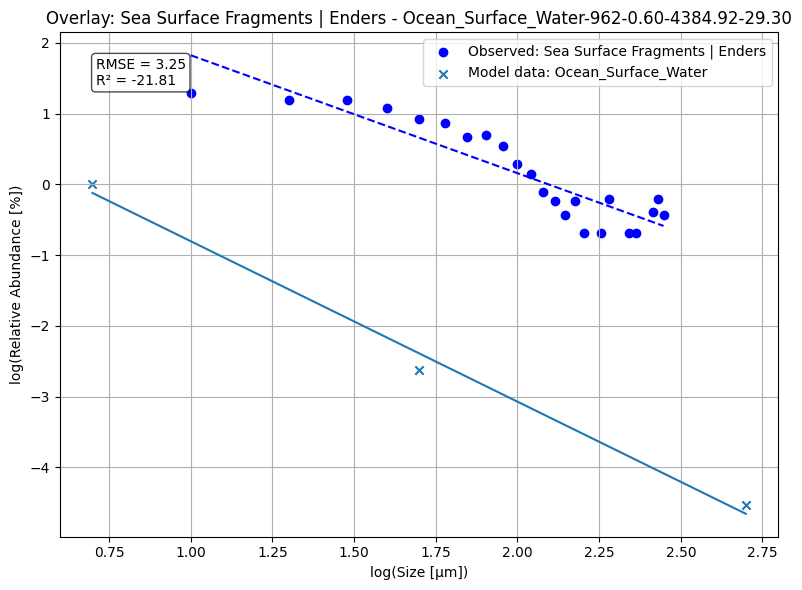

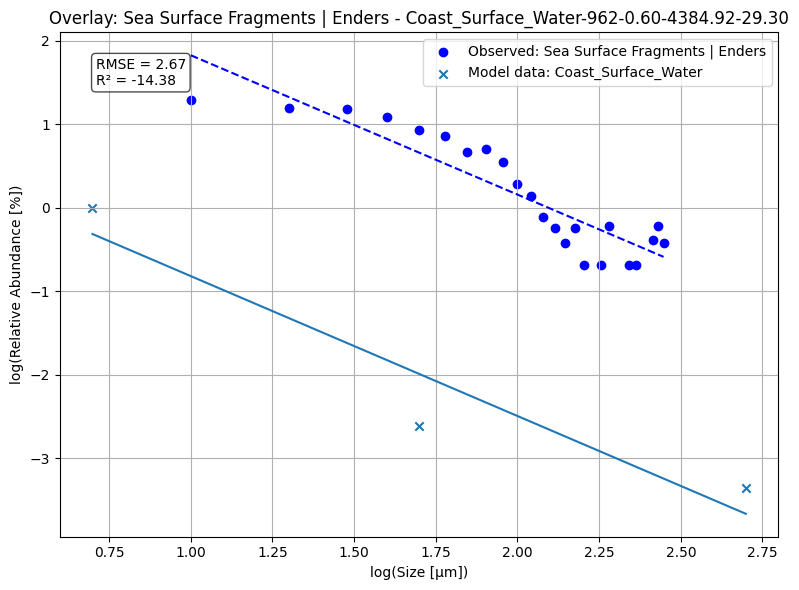

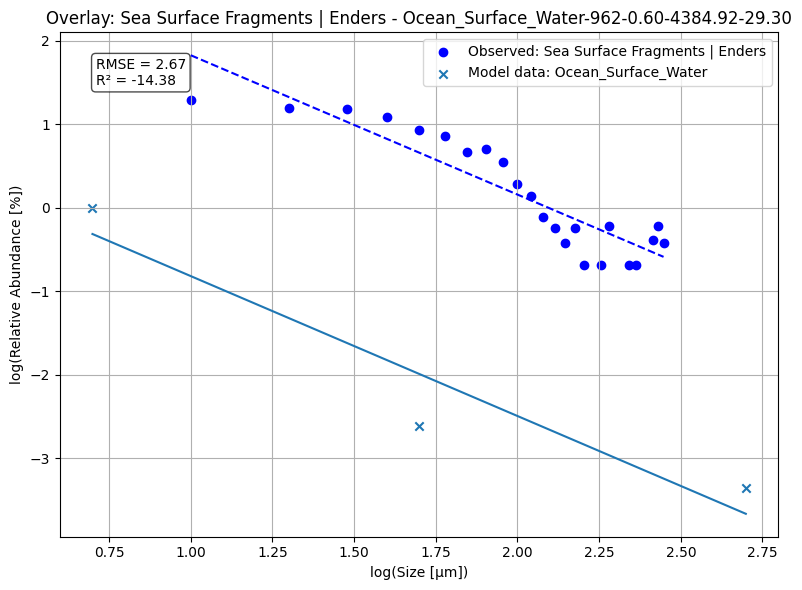

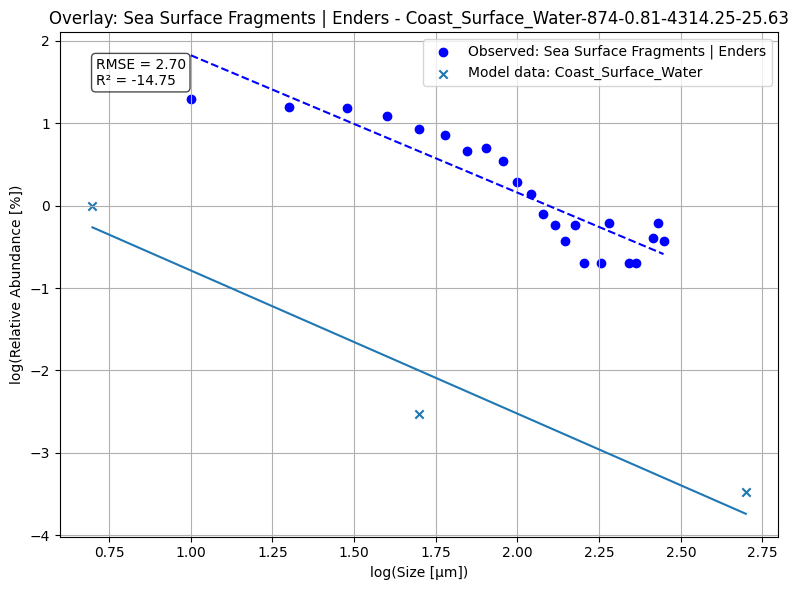

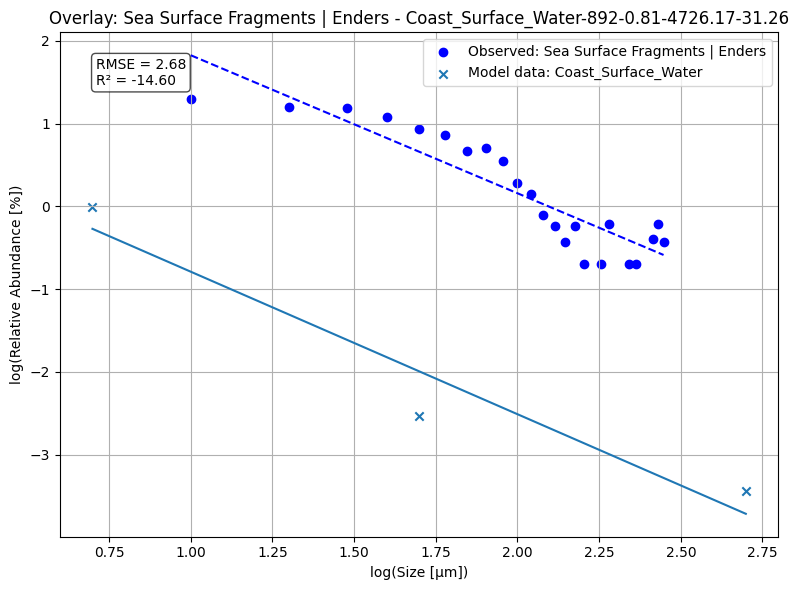

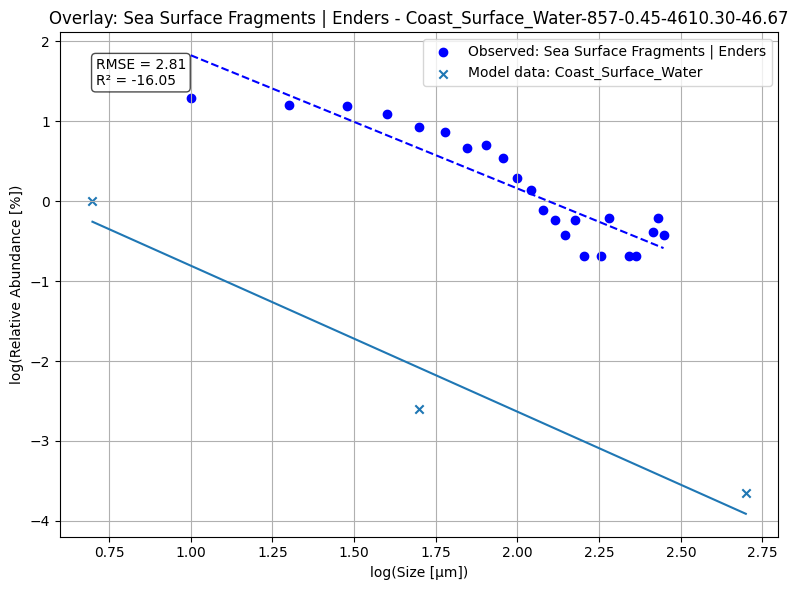

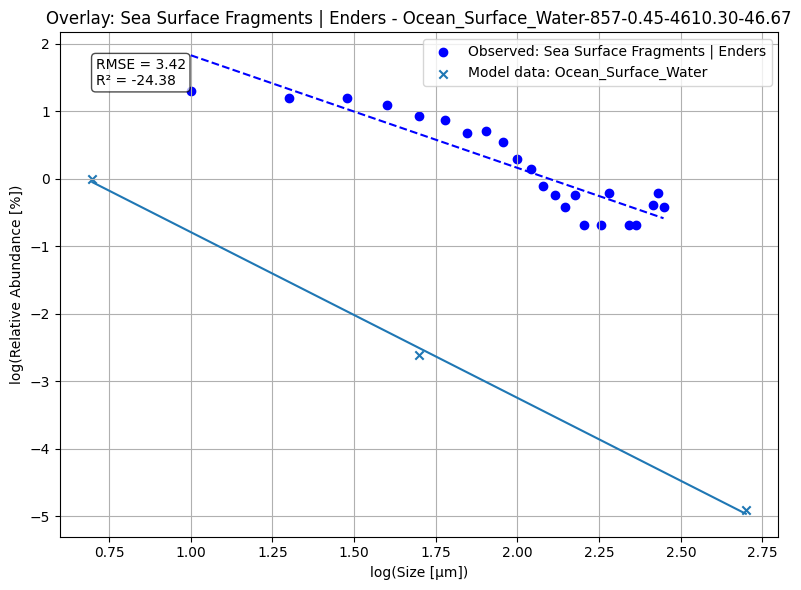

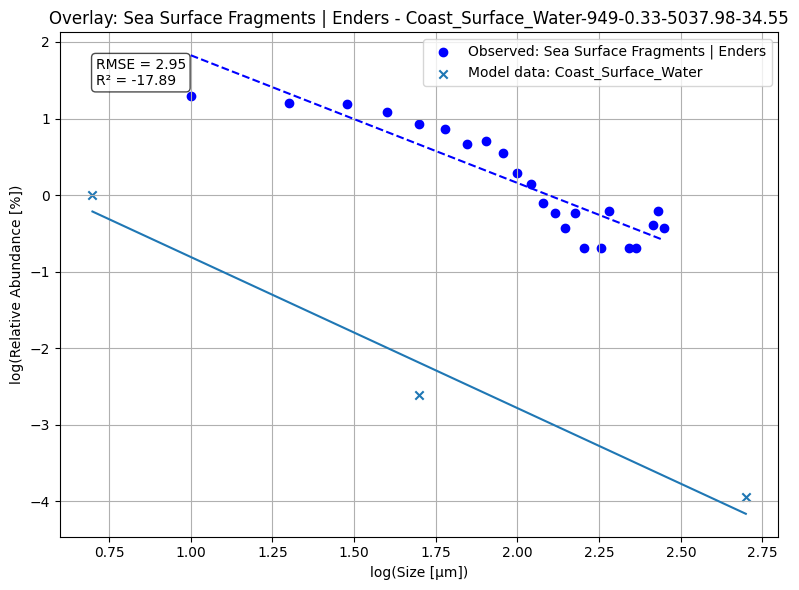

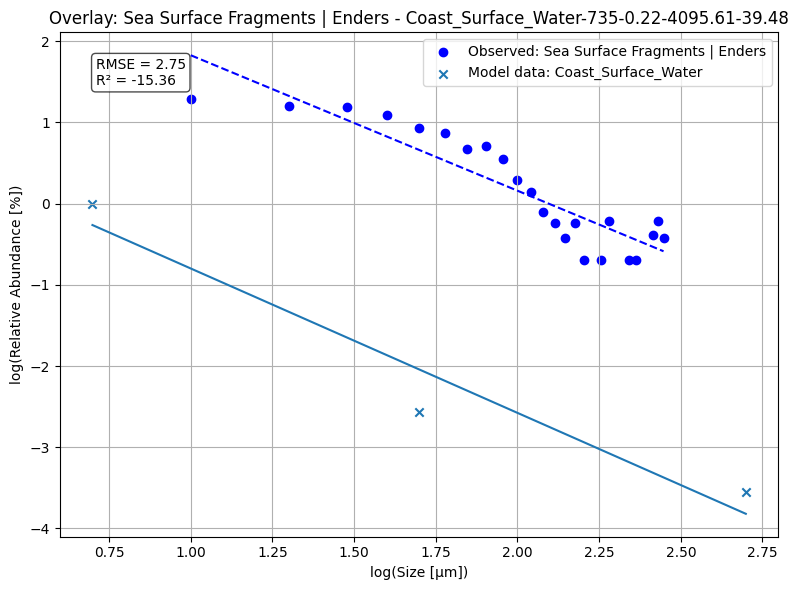

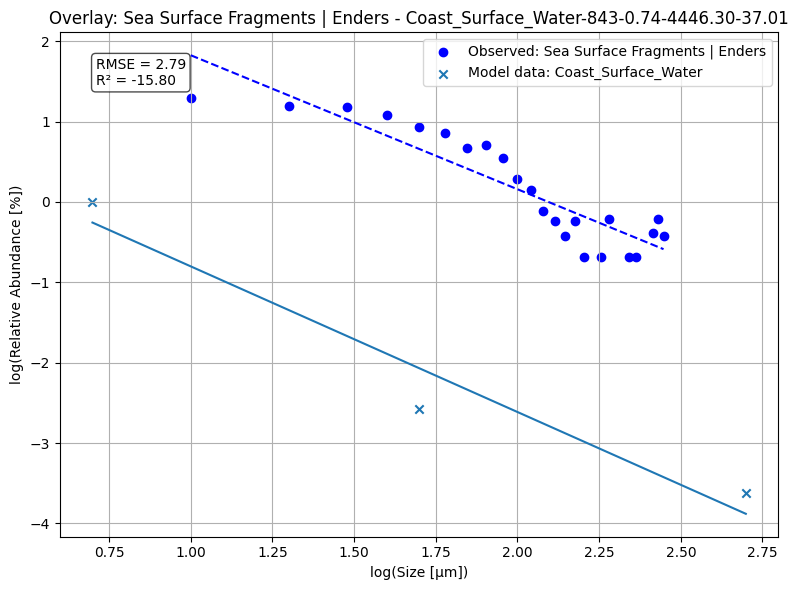

In [19]:
# Without Excluding smalles size fractions 0.5 and 5 um as they are not always reported in the observed datasets
run_and_plot_top_results(top_results)

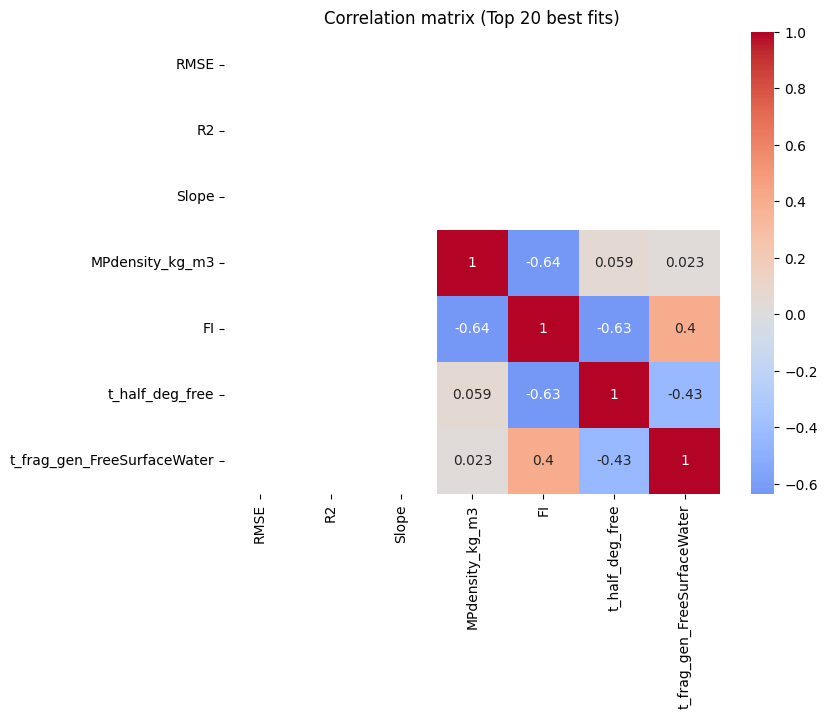

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap for the top results
corr = top_results[["RMSE", "R2", "Slope", "MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation matrix (Top 20 best fits)")
plt.show()


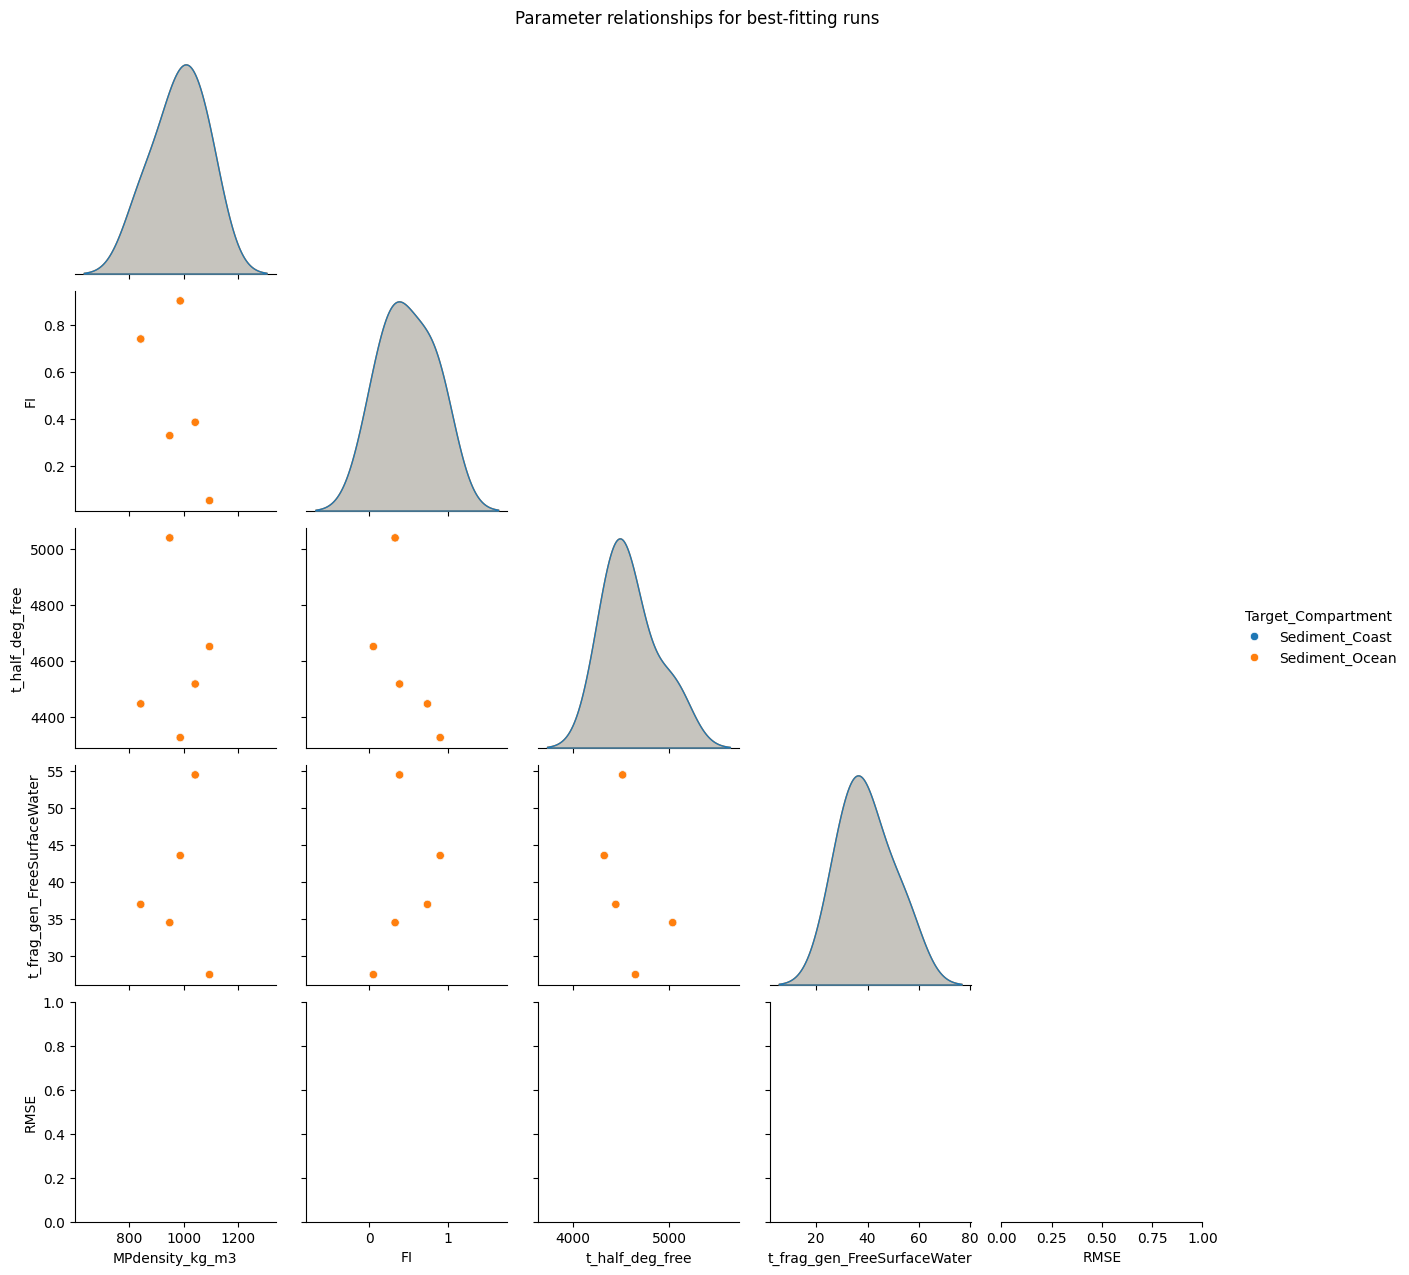

In [36]:
# Pair-wise relationships for the top results
sns.pairplot(
    top_results,
    vars=["MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater", "RMSE"],
    hue="Target_Compartment",
    corner=True
)
plt.suptitle("Parameter relationships for best-fitting runs", y=1.02)
plt.show()


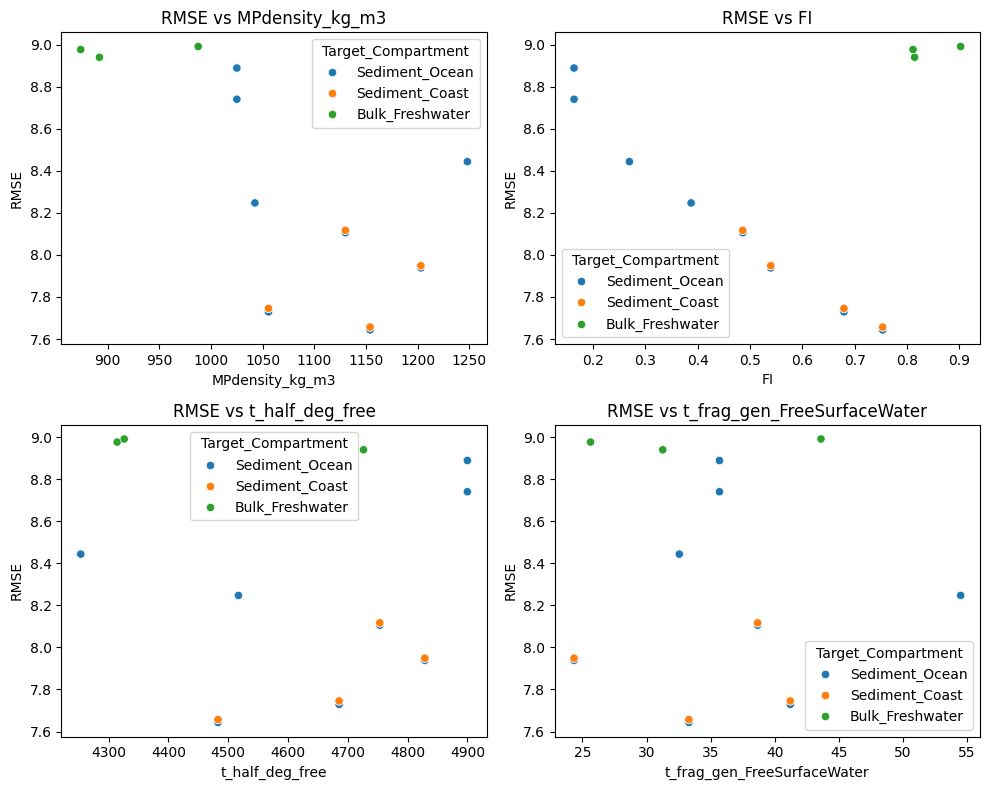

In [96]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

params = ["MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater"]

for ax, param in zip(axes.ravel(), params):
    sns.scatterplot(data=top_results, x=param, y="RMSE", hue="Target_Compartment", ax=ax)
    ax.set_title(f"RMSE vs {param}")

plt.tight_layout()
plt.show()


Pearson r = -0.185, p = 8.969e-15
Spearman ρ = -0.209, p = 1.963e-18


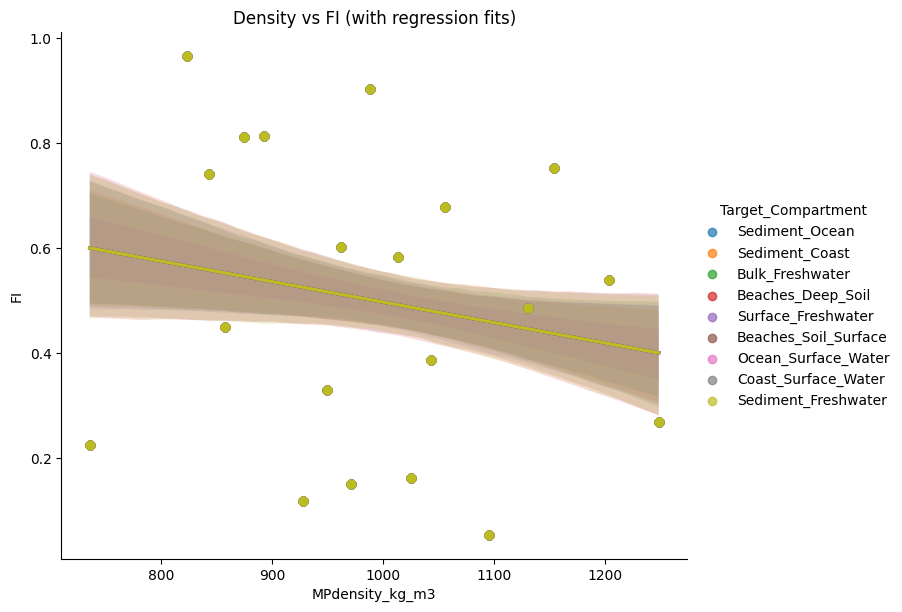

In [97]:
# Pearson & Spearman correlation between Density and FI for all results

# Pearson tests linear correlation.

# Spearman tests monotonic correlation (rank-based, robust to nonlinearities).

# If p < 0.05, the correlation is statistically significant.

from scipy.stats import pearsonr, spearmanr

x = results_sorted["MPdensity_kg_m3"]
y = results_sorted["FI"]

pearson_corr, pearson_p = pearsonr(x, y)
spearman_corr, spearman_p = spearmanr(x, y)

print(f"Pearson r = {pearson_corr:.3f}, p = {pearson_p:.3e}")
print(f"Spearman ρ = {spearman_corr:.3f}, p = {spearman_p:.3e}")

import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(
    data=results_sorted, 
    x="MPdensity_kg_m3", 
    y="FI", 
    hue="Target_Compartment", 
    height=6, aspect=1.2,
    scatter_kws={"alpha": 0.7}
)
plt.title("Density vs FI (with regression fits)")
plt.show()



Best fits Pearson r = -0.309


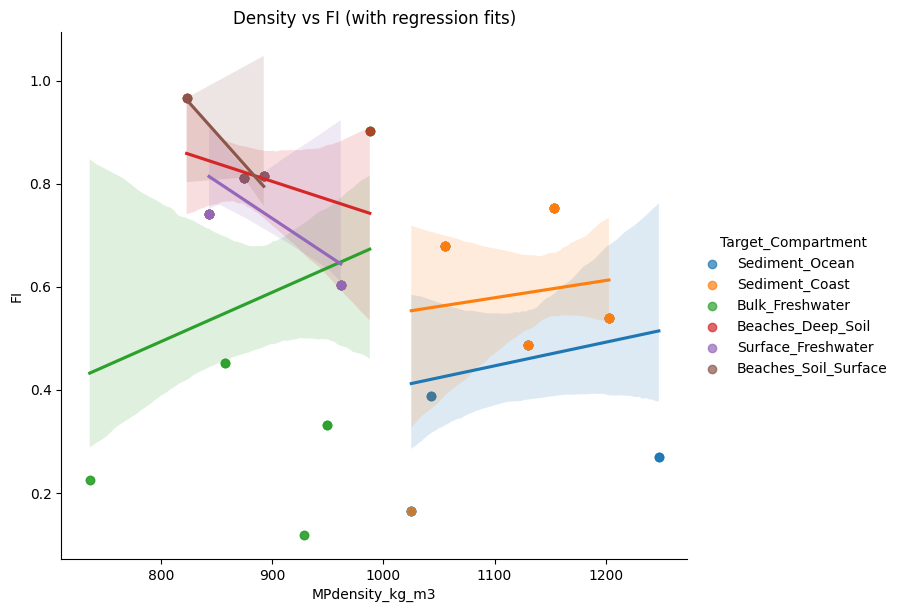

In [98]:

# Pearson & Spearman correlation between Density and FI for best fits (e.g. lowest 10% RMSE)

threshold = results_sorted["RMSE"].quantile(0.1)  # lowest 10% of RMSE
best_fits = results_sorted[results_sorted["RMSE"] <= threshold]

pearson_corr, _ = pearsonr(best_fits["MPdensity_kg_m3"], best_fits["FI"])
print(f"Best fits Pearson r = {pearson_corr:.3f}")


sns.lmplot(
    data=best_fits, 
    x="MPdensity_kg_m3", 
    y="FI", 
    hue="Target_Compartment", 
    height=6, aspect=1.2,
    scatter_kws={"alpha": 0.7}
)
plt.title("Density vs FI (with regression fits)")
plt.show()

In [99]:
from scipy.stats import pearsonr, spearmanr
import pandas as pd

# Keep only best 10% RMSE across all compartments
threshold = results_sorted["RMSE"].quantile(0.1)
best_fits = results_sorted[results_sorted["RMSE"] <= threshold]

results = []

for comp in best_fits["Target_Compartment"].unique():
    subset = best_fits[best_fits["Target_Compartment"] == comp]
    
    if len(subset) > 2:  # need at least 3 points
        pearson_corr, pearson_p = pearsonr(subset["MPdensity_kg_m3"], subset["FI"])
        spearman_corr, spearman_p = spearmanr(subset["MPdensity_kg_m3"], subset["FI"])
    else:
        pearson_corr, pearson_p, spearman_corr, spearman_p = [None]*4
    
    results.append({
        "Target_Compartment": comp,
        "Pearson_r": pearson_corr,
        "Pearson_p": pearson_p,
        "Spearman_rho": spearman_corr,
        "Spearman_p": spearman_p,
        "n_points": len(subset)
    })

correlation_best = pd.DataFrame(results)
print(correlation_best)


     Target_Compartment  Pearson_r  Pearson_p  Spearman_rho  Spearman_p  \
0        Sediment_Ocean   0.180744   0.420855      0.378238    0.082618   
1        Sediment_Coast   0.130467   0.617711      0.175258    0.501073   
2       Bulk_Freshwater   0.253005   0.222376      0.286381    0.165177   
3     Beaches_Deep_Soil  -0.355942   0.312752     -0.254658    0.477677   
4    Surface_Freshwater  -0.726701   0.007425     -0.200000    0.533135   
5  Beaches_Soil_Surface  -0.975257   0.024743     -0.777778    0.222222   

   n_points  
0        22  
1        17  
2        25  
3        10  
4        12  
5         4  


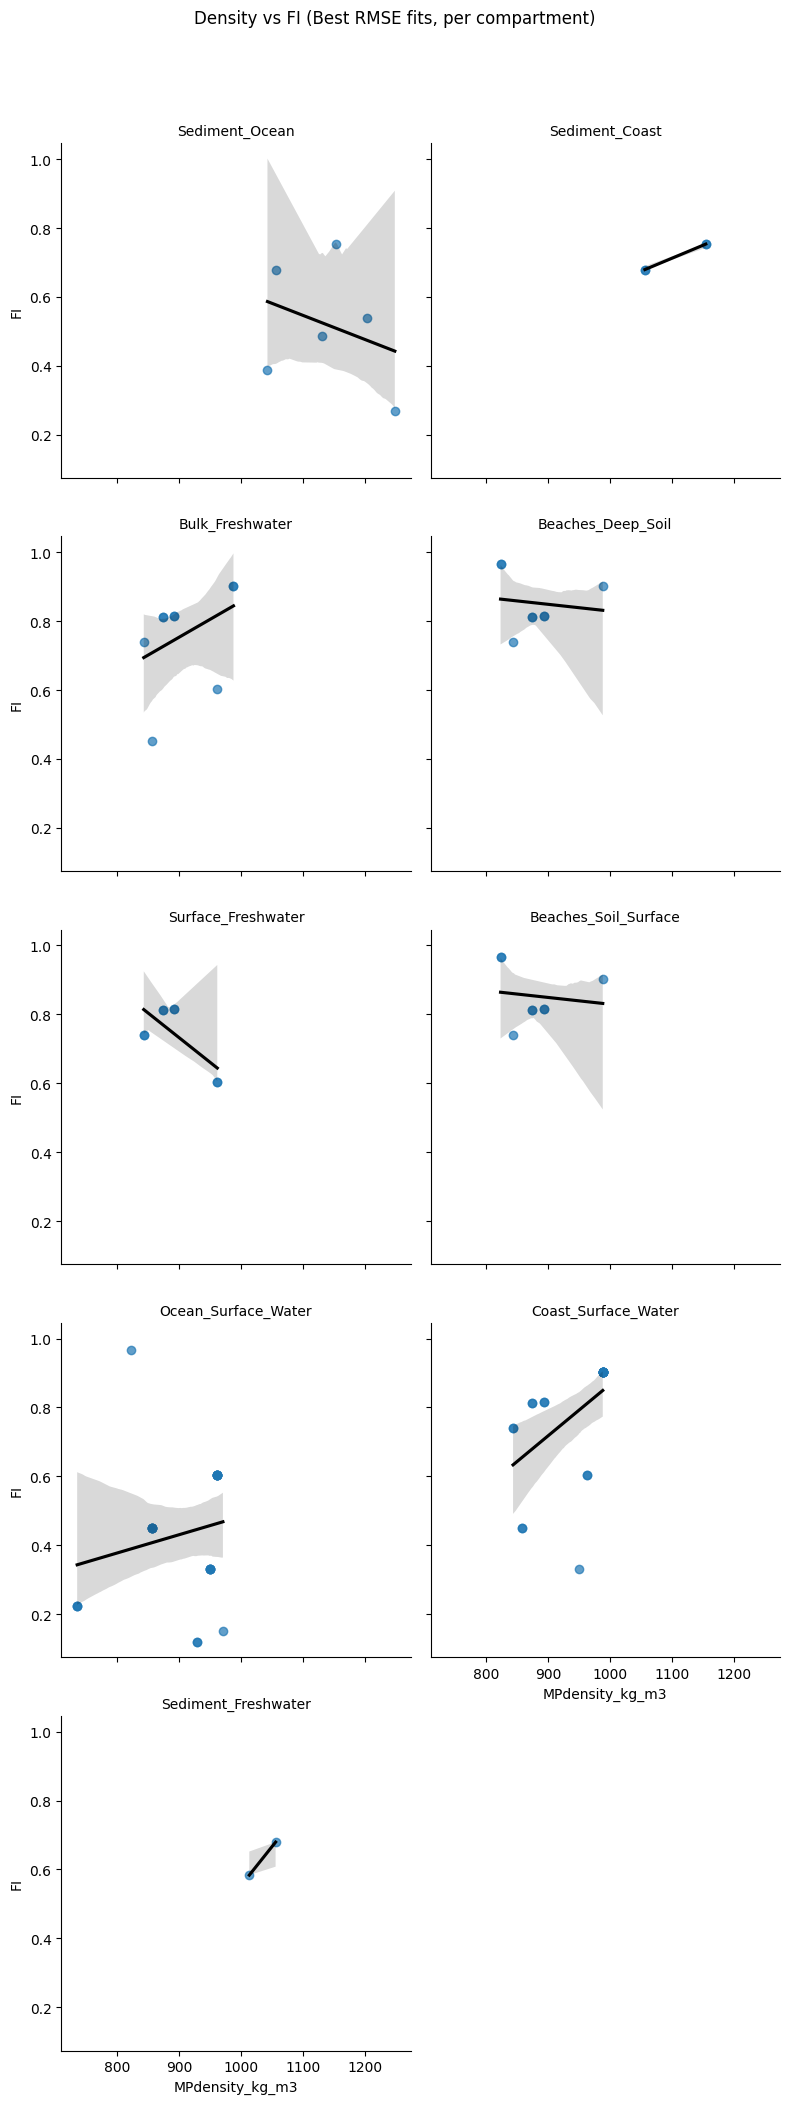

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- pick best fits per compartment (lowest 10% RMSE) ---
best_fits_list = []

for comp in results_sorted["Target_Compartment"].unique():
    subset = results_sorted[results_sorted["Target_Compartment"] == comp]
    if len(subset) > 2:
        threshold = subset["RMSE"].quantile(0.1)   # lowest 10%
        best_subset = subset[subset["RMSE"] <= threshold]
        best_fits_list.append(best_subset)

best_fits = pd.concat(best_fits_list, ignore_index=True)

# --- plot each compartment separately ---
g = sns.lmplot(
    data=best_fits,
    x="MPdensity_kg_m3",
    y="FI",
    col="Target_Compartment",   # separate plot per compartment
    col_wrap=2,                 # wrap panels (2 per row)
    height=4,
    scatter_kws={"alpha": 0.7},
    line_kws={"color": "black"}
)

g.set_titles("{col_name}")
plt.suptitle("Density vs FI (Best RMSE fits, per compartment)", y=1.05)
plt.show()



### Plot sensitivity indices for each output variable.  Monaco uses the D-VARS approach to calculating global sensitivity indices.

In [101]:
sim.outvars

{'Coast_Surface_Water_Spearman_r': <monaco.mc_var.OutVar at 0x24b58af4310>,
 'Coast_Surface_Water_Spearman_p': <monaco.mc_var.OutVar at 0x24b584f7990>,
 'Coast_Surface_Water_Pass_Spearman': <monaco.mc_var.OutVar at 0x24b58198410>,
 'Coast_Surface_Water_RMSE': <monaco.mc_var.OutVar at 0x24b56c12a90>,
 'Coast_Surface_Water_R_squared': <monaco.mc_var.OutVar at 0x24b592d0a90>,
 'Coast_Surface_Water_Model_slope': <monaco.mc_var.OutVar at 0x24b588f4f10>,
 'Coast_Surface_Water_Model_intercept': <monaco.mc_var.OutVar at 0x24b588f51d0>,
 'Ocean_Surface_Water_Spearman_r': <monaco.mc_var.OutVar at 0x24b588f6e10>,
 'Ocean_Surface_Water_Spearman_p': <monaco.mc_var.OutVar at 0x24b592d2a90>,
 'Ocean_Surface_Water_Pass_Spearman': <monaco.mc_var.OutVar at 0x24b588f5e10>,
 'Ocean_Surface_Water_RMSE': <monaco.mc_var.OutVar at 0x24b588f4090>,
 'Ocean_Surface_Water_R_squared': <monaco.mc_var.OutVar at 0x24b588f76d0>,
 'Ocean_Surface_Water_Model_slope': <monaco.mc_var.OutVar at 0x24b588f6250>,
 'Ocean_Surfa

In [102]:
sim.calcSensitivities("C_g_m3_Ocean_Surface_Water")
fig, ax = sim.outvars["C_g_m3_Ocean_Surface_Water"].plotSensitivities()

KeyError: 'C_g_m3_Ocean_Surface_Water'

Calculating sensitivity indices for 'persistence_number'...
Calculating optimal hyperparameters Φ for 'persistence_number' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


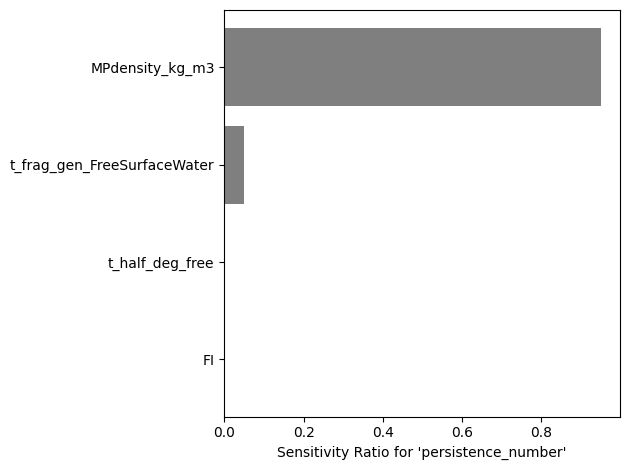

In [103]:
sim.calcSensitivities("persistence_number")
fig, ax = sim.outvars["persistence_number"].plotSensitivities()

Variable: Coast_Surface_Water_Spearman_r
Calculating sensitivity indices for 'Coast_Surface_Water_Spearman_r'...
Calculating optimal hyperparameters Φ for 'Coast_Surface_Water_Spearman_r' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


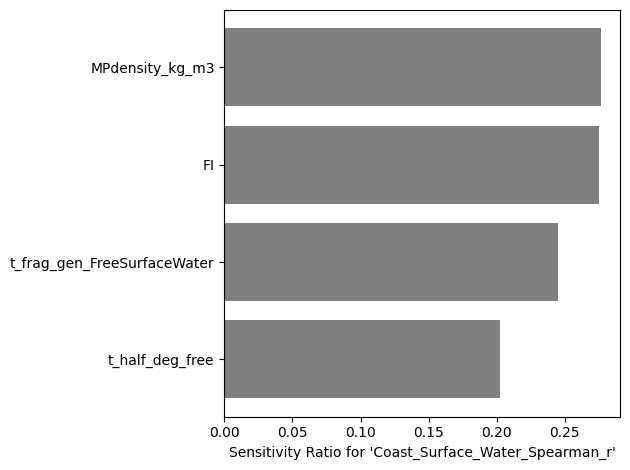

Variable: Coast_Surface_Water_Spearman_p
Calculating sensitivity indices for 'Coast_Surface_Water_Spearman_p'...
Calculating optimal hyperparameters Φ for 'Coast_Surface_Water_Spearman_p' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


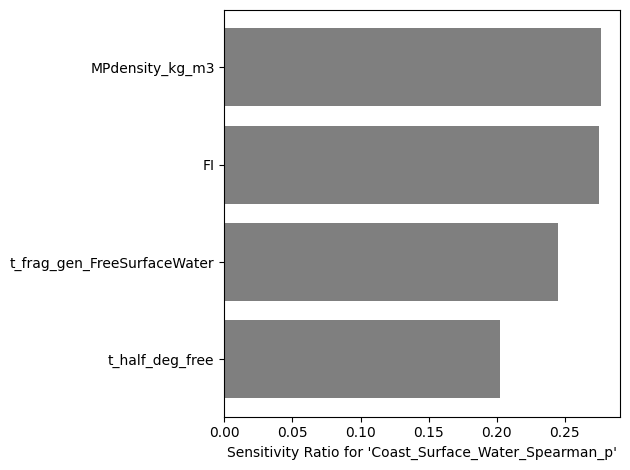

Variable: Coast_Surface_Water_Pass_Spearman
Calculating sensitivity indices for 'Coast_Surface_Water_Pass_Spearman'...
Calculating optimal hyperparameters Φ for 'Coast_Surface_Water_Pass_Spearman' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


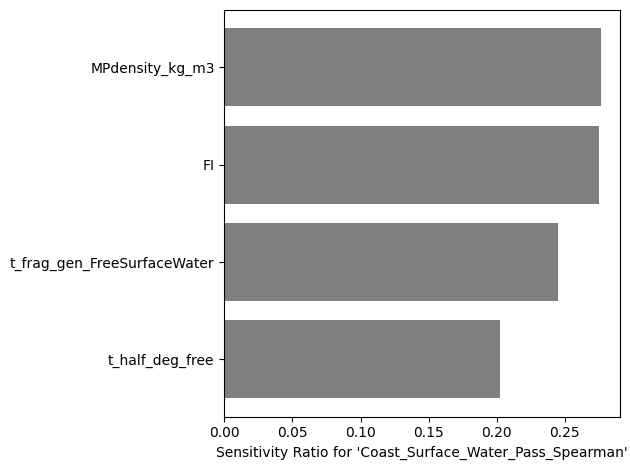

Variable: Coast_Surface_Water_RMSE
Calculating sensitivity indices for 'Coast_Surface_Water_RMSE'...
Calculating optimal hyperparameters Φ for 'Coast_Surface_Water_RMSE' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


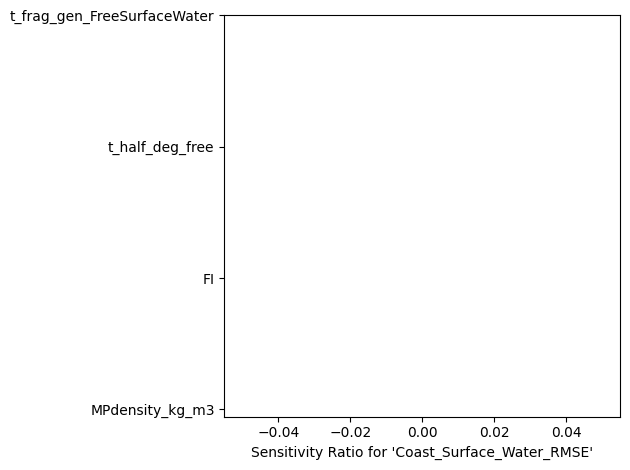

Variable: Coast_Surface_Water_R_squared
Calculating sensitivity indices for 'Coast_Surface_Water_R_squared'...
Calculating optimal hyperparameters Φ for 'Coast_Surface_Water_R_squared' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


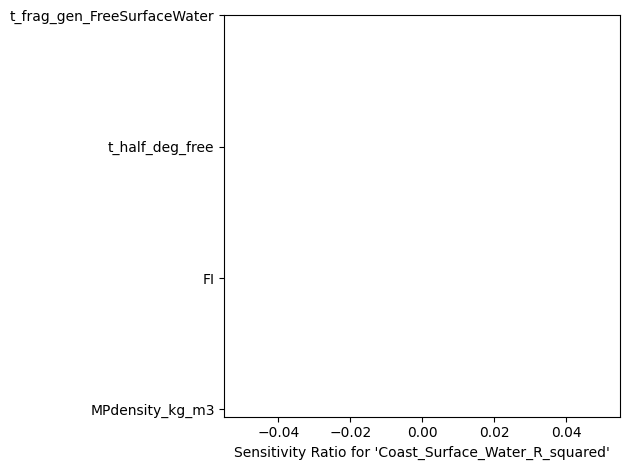

Variable: Coast_Surface_Water_Model_slope
Calculating sensitivity indices for 'Coast_Surface_Water_Model_slope'...
Calculating optimal hyperparameters Φ for 'Coast_Surface_Water_Model_slope' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


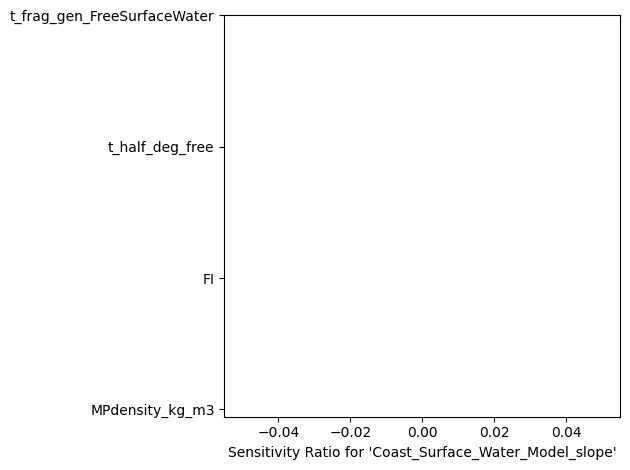

Variable: Coast_Surface_Water_Model_intercept
Calculating sensitivity indices for 'Coast_Surface_Water_Model_intercept'...
Calculating optimal hyperparameters Φ for 'Coast_Surface_Water_Model_intercept' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


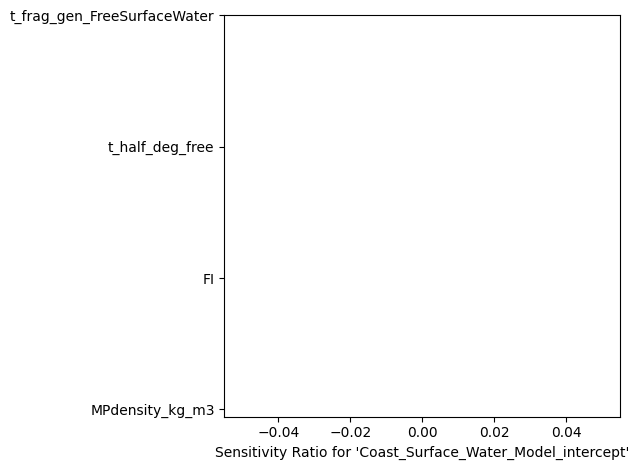

Variable: Ocean_Surface_Water_Spearman_r
Calculating sensitivity indices for 'Ocean_Surface_Water_Spearman_r'...
Calculating optimal hyperparameters Φ for 'Ocean_Surface_Water_Spearman_r' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


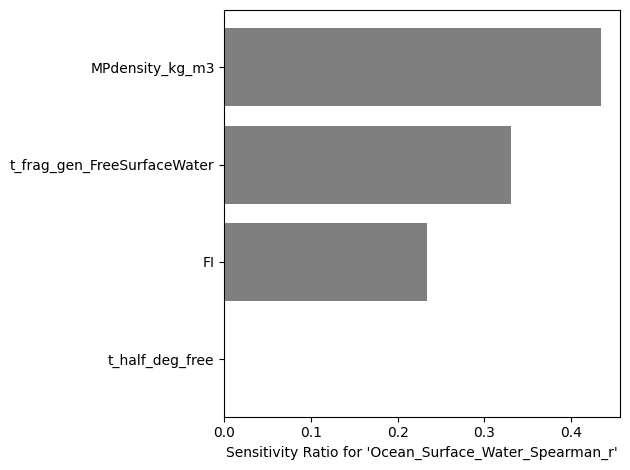

Variable: Ocean_Surface_Water_Spearman_p
Calculating sensitivity indices for 'Ocean_Surface_Water_Spearman_p'...
Calculating optimal hyperparameters Φ for 'Ocean_Surface_Water_Spearman_p' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


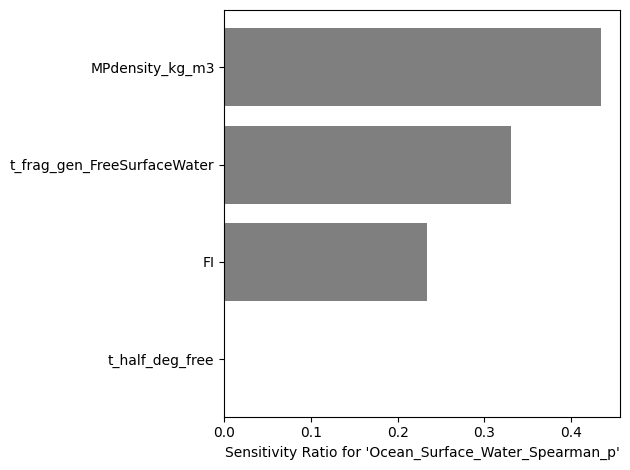

Variable: Ocean_Surface_Water_Pass_Spearman
Calculating sensitivity indices for 'Ocean_Surface_Water_Pass_Spearman'...
Calculating optimal hyperparameters Φ for 'Ocean_Surface_Water_Pass_Spearman' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


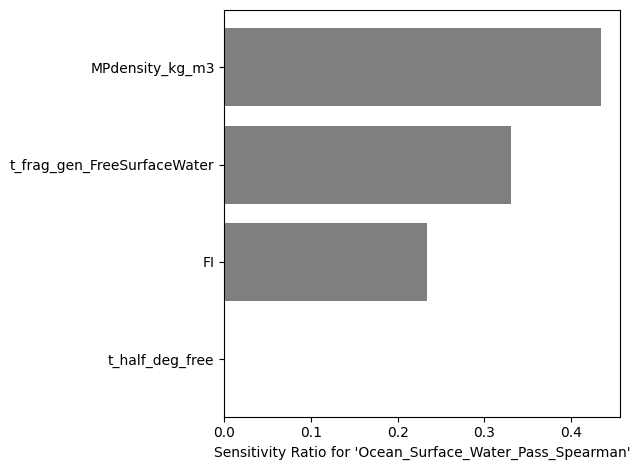

Variable: Ocean_Surface_Water_RMSE
Calculating sensitivity indices for 'Ocean_Surface_Water_RMSE'...
Calculating optimal hyperparameters Φ for 'Ocean_Surface_Water_RMSE' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


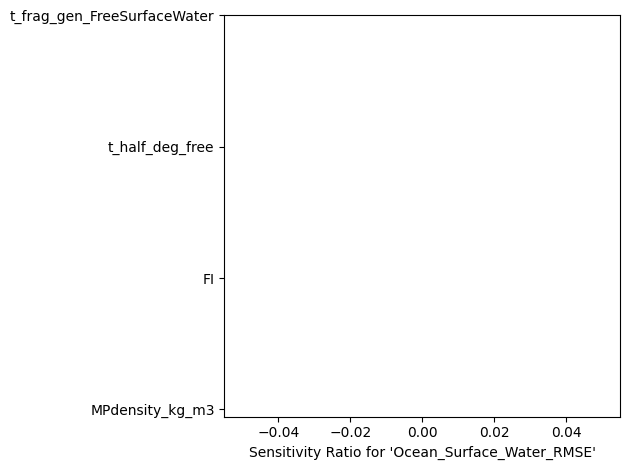

Variable: Ocean_Surface_Water_R_squared
Calculating sensitivity indices for 'Ocean_Surface_Water_R_squared'...
Calculating optimal hyperparameters Φ for 'Ocean_Surface_Water_R_squared' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


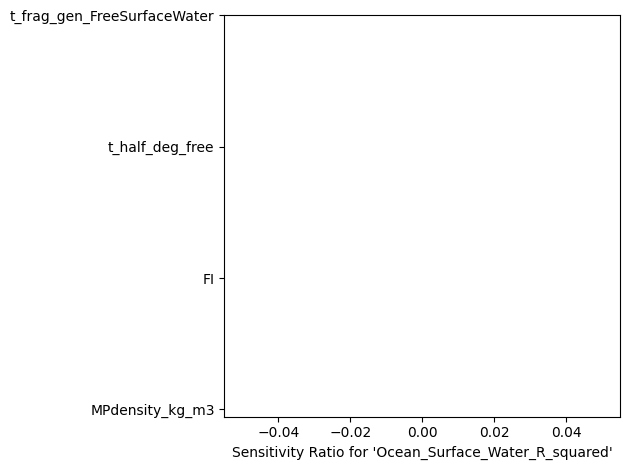

Variable: Ocean_Surface_Water_Model_slope
Calculating sensitivity indices for 'Ocean_Surface_Water_Model_slope'...
Calculating optimal hyperparameters Φ for 'Ocean_Surface_Water_Model_slope' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


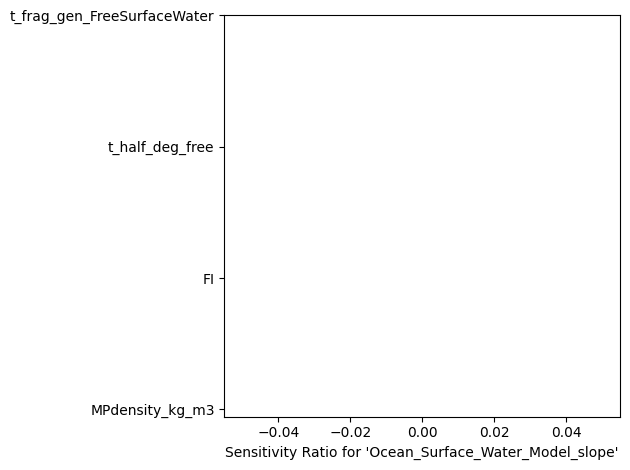

Variable: Ocean_Surface_Water_Model_intercept
Calculating sensitivity indices for 'Ocean_Surface_Water_Model_intercept'...
Calculating optimal hyperparameters Φ for 'Ocean_Surface_Water_Model_intercept' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


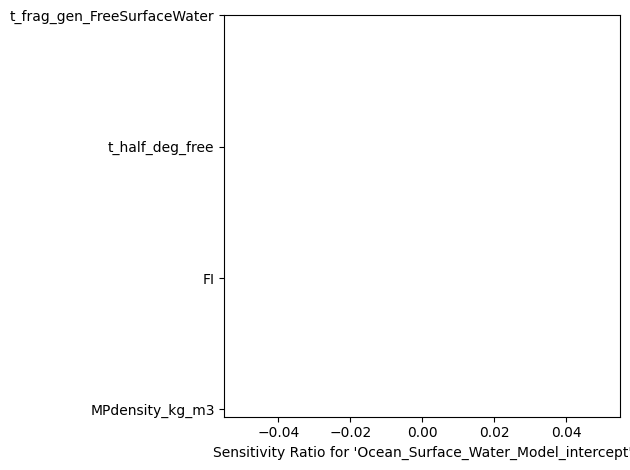

Variable: residence_time_mass
Calculating sensitivity indices for 'residence_time_mass'...
Calculating optimal hyperparameters Φ for 'residence_time_mass' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


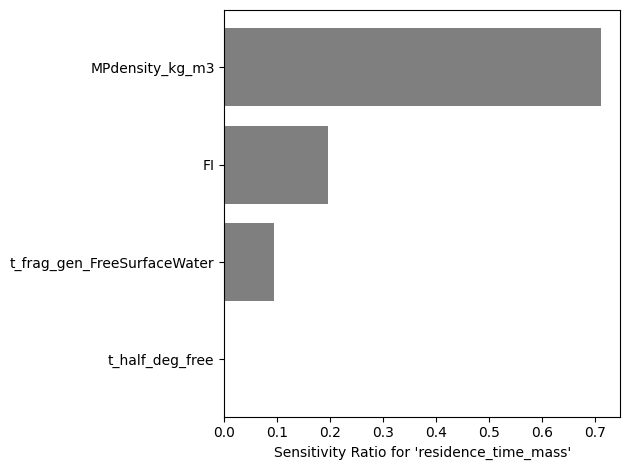

Variable: residence_time_number
Calculating sensitivity indices for 'residence_time_number'...
Calculating optimal hyperparameters Φ for 'residence_time_number' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


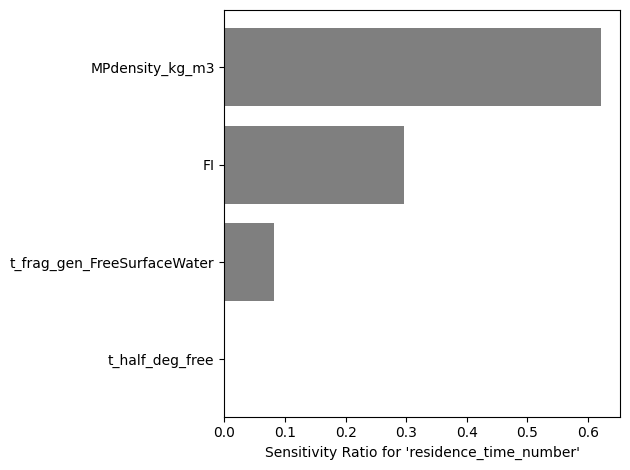

Variable: persistence_mass
Calculating sensitivity indices for 'persistence_mass'...
Calculating optimal hyperparameters Φ for 'persistence_mass' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


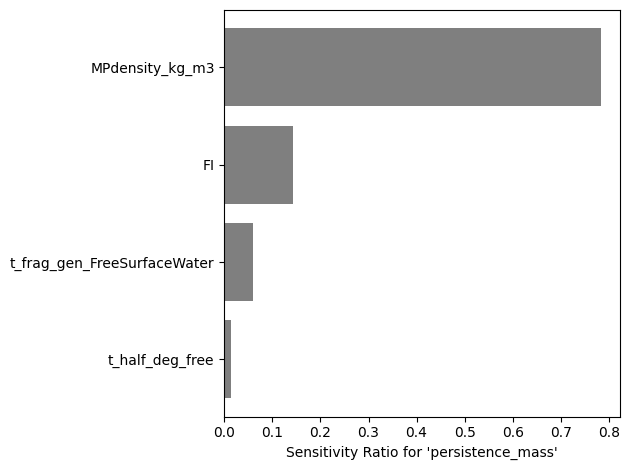

Variable: persistence_number
Calculating sensitivity indices for 'persistence_number'...
Calculating optimal hyperparameters Φ for 'persistence_number' covariances...
Done calculating optimal hyperparameters.
Done calculating sensitivity indices.


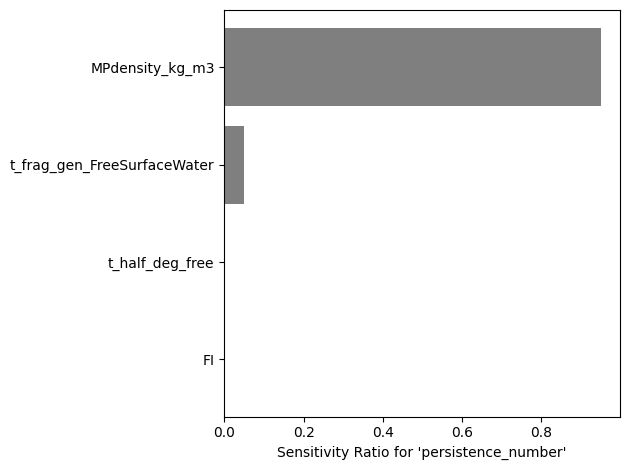

In [104]:
import matplotlib.pyplot as plt

for var in sim.outvars:
    print(f"Variable: {var}")
    sim.calcSensitivities(var)
    fig, ax = sim.outvars[var].plotSensitivities()

    plt.show()

### Plot 

(<Figure size 640x480 with 3 Axes>,
 (<Axes: xlabel='MPdensity_kg_m3'>,
  <Axes: ylabel='residence_time_number'>,
  <Axes: >))

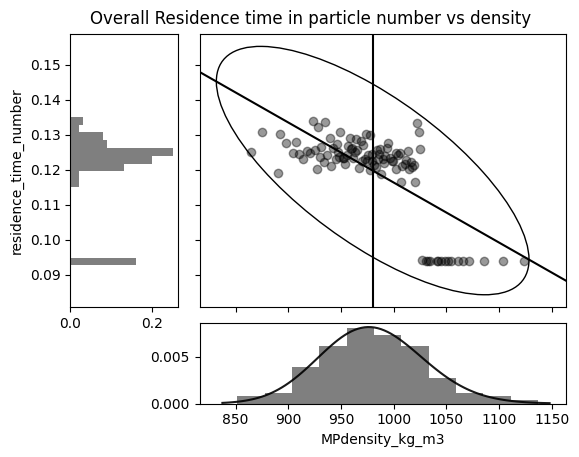

In [ ]:
import monaco as mc

mc.multi_plot([sim.invars["MPdensity_kg_m3"],sim.outvars["residence_time_number"]],title="Overall Residence time in particle number vs density",cov_plot=True)

(<Figure size 640x480 with 3 Axes>,
 (<Axes: xlabel='MPdensity_kg_m3'>,
  <Axes: ylabel='C_g_m3_Ocean_Surface_Water'>,
  <Axes: >))

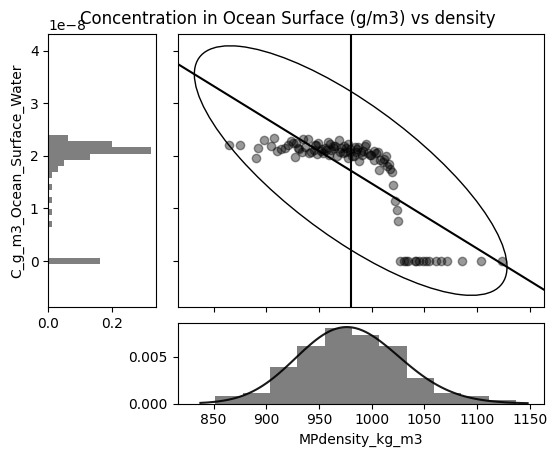

In [ ]:

mc.multi_plot([sim.invars["MPdensity_kg_m3"],sim.outvars["C_g_m3_Ocean_Surface_Water"]],title="Concentration in Ocean Surface (g/m3) vs density",cov_plot=True)

Test

In [4]:
# Reproduce best performing parameters sets from Rakesh
art= "Sea Surface Fibers | Song"


In [7]:
# Run the Monte Carlo analysis with the specified parameters distributions and number of cases for specified emission scenarios related to the obsserved data from articles in the list.


for comp in overlay_emission_scenarios[art]:
    # Set emissions to that compartment and include it in base_data file
    data_data["emiss_dict_g_s"]= set_emission(data_data["emiss_dict_g_s"].copy(), comp, "e", 100)
    # Run Monte Carlo analysis for each emission scenario
    sim= run_mc_analysis_paper(
    base_config=config_data,
    base_data=data_data,
    param_distributions=param_distributions,
    n_cases=20,art=art,
)
    # Convert sim results to dataframe
    df_MC_results = sim_to_dataframe(sim)
    
    #Transform dataframe to long format for easier processing
    input_params=["MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater","residence_time_mass","residence_time_number","persistence_mass","persistence_number"]
    compartments= overlay_compartments_mapping[art]
    dataset_name=art
    emission_comp=comp
    tidy=reshape_mc_results(df_MC_results, compartments, input_params, dataset_name, emission_comp)
    
    



Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 1586.35 cases/s]

Simulation complete! Runtime: 0:00:42.821141
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'SampleMethod.SOBOL_RANDOM' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 6216.55 cases/s]

Simulation complete! Runtime: 0:00:43.216754


In [8]:
tidy

,Case,Observed_dataset,Emission_Compartment,Target_Compartment,RMSE,R2,Slope,Spearman_r,Pass_Spearman,MPdensity_kg_m3,FI,t_half_deg_free,t_frag_gen_FreeSurfaceWater,residence_time_mass,residence_time_number,persistence_mass,persistence_number
0,0,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,NaN,NaN,NaN,-0.5,False,1094.898370,0.054891,4650.538854,27.531385,0.000009,1.281580,0.246402,361242.495727
1,0,Sea Surface Fibers | Song,Surface_Freshwater,Ocean_Surface_Water,NaN,NaN,NaN,-0.5,False,1094.898370,0.054891,4650.538854,27.531385,0.000009,1.281580,0.246402,361242.495727
2,1,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,NaN,NaN,NaN,-0.5,False,842.888643,0.740818,4446.304611,37.008962,0.017038,0.277613,0.017049,92417.969775
3,1,Sea Surface Fibers | Song,Surface_Freshwater,Ocean_Surface_Water,NaN,NaN,NaN,-0.5,False,842.888643,0.740818,4446.304611,37.008962,0.017038,0.277613,0.017049,92417.969775
4,2,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,1.660743,-29.887275,-0.951257,-1.0,True,949.180258,0.330629,5037.980205,34.549059,0.017731,0.280218,0.017755,106735.344310
5,2,Sea Surface Fibers | Song,Surface_Freshwater,Ocean_Surface_Water,NaN,NaN,NaN,-0.5,False,949.180258,0.330629,5037.980205,34.549059,0.017731,0.280218,0.017755,106735.344310
6,3,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,1.373812,-20.136321,-0.615685,-1.0,True,987.645770,0.902573,4326.028802,43.603462,0.019615,0.292647,0.019634,92658.031166
7,3,Sea Surface Fibers | Song,Surface_Freshwater,Ocean_Surface_Water,NaN,NaN,NaN,-0.5,False,987.645770,0.902573,4326.028802,43.603462,0.019615,0.292647,0.019634,92658.031166
8,4,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,NaN,NaN,NaN,-0.5,False,1042.497370,0.387262,4517.069869,54.495643,0.000014,1.253864,0.236283,346845.744326
9,4,Sea Surface Fibers | Song,Surface_Freshwater,Ocean_Surface_Water,5.358572,-320.567915,-3.567133,-1.0,True,1042.497370,0.387262,4517.069869,54.495643,0.000014,1.253864,0.236283,346845.744326


In [9]:
# Sort ascending by RMSE (best fits first)
results_sorted = tidy.sort_values("RMSE", ascending=True)

# Keep e.g. top 20 best-fitting combinations
top_results = results_sorted.head(10)
top_results

,Case,Observed_dataset,Emission_Compartment,Target_Compartment,RMSE,R2,Slope,Spearman_r,Pass_Spearman,MPdensity_kg_m3,FI,t_half_deg_free,t_frag_gen_FreeSurfaceWater,residence_time_mass,residence_time_number,persistence_mass,persistence_number
6,3,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,1.373812,-20.136321,-0.615685,-1.0,True,987.645770,0.902573,4326.028802,43.603462,0.019615,0.292647,0.019634,92658.031166
37,18,Sea Surface Fibers | Song,Surface_Freshwater,Ocean_Surface_Water,1.626071,-28.611048,-0.833754,-1.0,True,970.609711,0.151413,4655.556992,62.916102,0.017129,0.279733,0.017142,99116.609784
20,10,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,1.634481,-28.918123,-0.897864,-1.0,True,928.013133,0.118571,4555.026552,17.459733,0.016131,0.273289,0.016173,96688.831842
26,13,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,1.647079,-29.381114,-1.045468,-1.0,True,961.519499,0.603366,4384.922339,29.297538,0.017883,0.278564,0.017904,92222.175813
12,6,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,1.648838,-29.446034,-0.902397,-1.0,True,735.394318,0.224775,4095.613401,39.484788,0.013735,0.266271,0.013750,87012.403697
4,2,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,1.660743,-29.887275,-0.951257,-1.0,True,949.180258,0.330629,5037.980205,34.549059,0.017731,0.280218,0.017755,106735.344310
28,14,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,1.682816,-30.713758,-0.980112,-1.0,True,856.834375,0.450996,4610.300644,46.666868,0.015465,0.272570,0.015480,97730.533863
22,11,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,3.598996,-144.056562,-2.247080,-1.0,True,1055.656644,0.679468,4685.363804,41.206393,0.000012,1.290318,0.247442,364961.919127
30,15,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,3.605375,-144.571219,-2.271588,-1.0,True,1153.905470,0.753409,4482.848418,33.301045,0.000006,1.247750,0.234741,343534.545336
23,11,Sea Surface Fibers | Song,Surface_Freshwater,Ocean_Surface_Water,5.170811,-298.427650,-3.692248,-1.0,True,1055.656644,0.679468,4685.363804,41.206393,0.000012,1.290318,0.247442,364961.919127


In [10]:
from utopia.utopia import utopiaModel
from utopia.results_processing.process_results import *
from utopia.monte_carlo.montecarlo_analysis_paper import extract_log_rel_abundance, plot_obs_vs_model_with_metrics
def run_and_plot_top_results(top_results):
    observed_file = "../src/utopia/data/observed_data_long.xlsx"

    observed_df = pd.read_excel(observed_file)

    observed_df = observed_df.rename(
        columns={
            "dataset identifier": "Dataset",
            "Article name": "Article",
            "log‑transformed size": "log_Size",
            "log‑transformed abundance": "log_Abundance",
            }
        )
    for i in range(len(top_results)):
        art = top_results.iloc[i]["Observed_dataset"]
        comp_E = top_results.iloc[i]["Emission_Compartment"]
        comp_T= top_results.iloc[i]["Target_Compartment"]
        data_data["emiss_dict_g_s"]= set_emission(data_data["emiss_dict_g_s"].copy(), comp_E, "e", 100)
        data_data["MPdensity_kg_m3"]= top_results.iloc[i]["MPdensity_kg_m3"]
        data_data["FI"]= top_results.iloc[i]["FI"]
        data_data["t_half_deg_free"]= top_results.iloc[i]["t_half_deg_free"]
        data_data["t_frag_gen_FreeSurfaceWater"]= top_results.iloc[i]["t_frag_gen_FreeSurfaceWater"]
        model = utopiaModel(config=config_data, data=data_data)
        model.run()
        processor = ResultsProcessor(model)
        processor.estimate_flows()
        processor.generate_flows_dict()
        processor.process_results() 
        processor.extract_results_by_compartment()
        df = processor.results_by_comp
        df2 = processor.Results_extended
        processor.estimate_exposure_indicators()
        model_df=df2.copy()
        excluded_sizes = [0.5, 5]
        filtered_Results = model_df[
            ~model_df["Size_Fraction_um"].isin(excluded_sizes)
        ]
        rel_abun = extract_log_rel_abundance(
            filtered_Results,
            compartment=comp,
            value_col="number_of_particles",
    )
        
        input_dict={"MPdensity_kg_m3":data_data["MPdensity_kg_m3"],"FI":data_data["FI"],"t_half_deg_free":data_data["t_half_deg_free"],"t_frag_gen_FreeSurfaceWater":data_data["t_frag_gen_FreeSurfaceWater"]}
        
        obs_subset = observed_df[observed_df["Article"] == art]
        
        plot_obs_vs_model_with_metrics(obs_df=obs_subset, model_df=rel_abun, compartment=comp_T, art=art,input_dict=input_dict)

In [ ]:
def plot_obs_vs_model_with_metrics(obs_df, model_df, compartment, art,input_dict):
    """ Plot observed vs modeled log-abundance by size with regression and metrics.
    
    Parameters
    ----------
    obs_df : pd.DataFrame
        Observed dataset with columns x_col and y_obs_col
    model_df : pd.DataFrame
        Modeled dataset with columns x_col and y_mod_col
    compartment : str
        Name of the compartment for title
    art : str
        Name of the article for title"""
    
    x_obs_all = obs_df["log_Size"].astype(float).values
    y_obs_all = obs_df["log_Abundance"].astype(float).values

    x_mod_all = model_df["log_size"].values
    y_mod_all = model_df["log_rel_abundance"].values

    # Fit powerlaw on observed dataset 
    if len(x_obs_all) >= 2:
        slope_obs, intercept_obs = np.polyfit(x_obs_all, y_obs_all, 1)
        x_fit_obs = np.linspace(x_obs_all.min(), x_obs_all.max(), 100)
        y_fit_obs = slope_obs * x_fit_obs + intercept_obs
        
        plt.figure(figsize=(8, 6))
        plt.scatter(x_obs_all, y_obs_all, color='blue', marker='o',
                    label=f"Observed: {art}")
        if x_fit_obs is not None:
            plt.plot(x_fit_obs, y_fit_obs, color='blue', linestyle='--',
                        label="_nolegend_")

    # Plot modelled dataset (filtered for excluded sizes)
    plt.scatter(x_mod_all, y_mod_all,marker='x', label=f"Model data: {comp}")
    slope_mod, intercept_mod = np.nan, np.nan
    if len(x_mod_all) >= 2:
        slope_mod, intercept_mod = np.polyfit(x_mod_all, y_mod_all, 1)
        x_fit_mod = np.linspace(x_mod_all.min(), x_mod_all.max(), 100)
        y_fit_mod = slope_mod*x_fit_mod + intercept_mod
        plt.plot(x_fit_mod, y_fit_mod, label="_nolegend_")

    # Compute metrics
    if len(x_obs_all) < 2 or len(x_mod_all) < 2:
        r2 = np.nan
        rmse = np.nan
        euclid_dist = np.nan
        n_points = 0
    else:
        # Intersection range
        x_min = max(x_obs_all.min(), x_mod_all.min())
        x_max = min(x_obs_all.max(), x_mod_all.max())
        mask_obs = (x_obs_all >= x_min) & (x_obs_all <= x_max)
        x_obs_filt = x_obs_all[mask_obs]
        y_obs_filt = y_obs_all[mask_obs]

        if len(x_obs_filt) < 2:
            r2 = np.nan
            rmse = np.nan
            n_points = len(x_obs_filt)
        else:
            pred_y = slope_mod*x_obs_filt + intercept_mod
            ss_res = np.sum((y_obs_filt - pred_y)**2)
            ss_tot = np.sum((y_obs_filt - y_obs_filt.mean())**2)
            r2 = 1 - ss_res/ss_tot if ss_tot != 0 else np.nan
            rmse = np.sqrt(ss_res/len(x_obs_filt))
            n_points = len(x_obs_filt)

        if not np.isnan(slope_mod) and not np.isnan(slope_obs):
            euclid_dist = np.sqrt((slope_mod - slope_obs)**2 + (intercept_mod - intercept_obs)**2)
        else:
            euclid_dist = np.nan
    plt.xlabel("log(Size [µm])")
    plt.ylabel("log(Relative Abundance [%])")
    plt.title(f"Overlay: {art} - {compartment}"-{input_dict['MPdensity_kg_m3']:.0f}-{input_dict['FI']:.2f}-{input_dict['t_half_deg_free']:.2f}-{input_dict['t_frag_gen_FreeSurfaceWater']:.2f}")
    # Annotate metrics
    plt.text(0.05, 0.95, f"RMSE = {rmse:.2f}\nR² = {r2:.2f}", transform=plt.gca().transAxes,
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

In [12]:
top_results

,Case,Observed_dataset,Emission_Compartment,Target_Compartment,RMSE,R2,Slope,Spearman_r,Pass_Spearman,MPdensity_kg_m3,FI,t_half_deg_free,t_frag_gen_FreeSurfaceWater,residence_time_mass,residence_time_number,persistence_mass,persistence_number
6,3,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,1.373812,-20.136321,-0.615685,-1.0,True,987.645770,0.902573,4326.028802,43.603462,0.019615,0.292647,0.019634,92658.031166
37,18,Sea Surface Fibers | Song,Surface_Freshwater,Ocean_Surface_Water,1.626071,-28.611048,-0.833754,-1.0,True,970.609711,0.151413,4655.556992,62.916102,0.017129,0.279733,0.017142,99116.609784
20,10,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,1.634481,-28.918123,-0.897864,-1.0,True,928.013133,0.118571,4555.026552,17.459733,0.016131,0.273289,0.016173,96688.831842
26,13,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,1.647079,-29.381114,-1.045468,-1.0,True,961.519499,0.603366,4384.922339,29.297538,0.017883,0.278564,0.017904,92222.175813
12,6,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,1.648838,-29.446034,-0.902397,-1.0,True,735.394318,0.224775,4095.613401,39.484788,0.013735,0.266271,0.013750,87012.403697
4,2,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,1.660743,-29.887275,-0.951257,-1.0,True,949.180258,0.330629,5037.980205,34.549059,0.017731,0.280218,0.017755,106735.344310
28,14,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,1.682816,-30.713758,-0.980112,-1.0,True,856.834375,0.450996,4610.300644,46.666868,0.015465,0.272570,0.015480,97730.533863
22,11,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,3.598996,-144.056562,-2.247080,-1.0,True,1055.656644,0.679468,4685.363804,41.206393,0.000012,1.290318,0.247442,364961.919127
30,15,Sea Surface Fibers | Song,Surface_Freshwater,Coast_Surface_Water,3.605375,-144.571219,-2.271588,-1.0,True,1153.905470,0.753409,4482.848418,33.301045,0.000006,1.247750,0.234741,343534.545336
23,11,Sea Surface Fibers | Song,Surface_Freshwater,Ocean_Surface_Water,5.170811,-298.427650,-3.692248,-1.0,True,1055.656644,0.679468,4685.363804,41.206393,0.000012,1.290318,0.247442,364961.919127


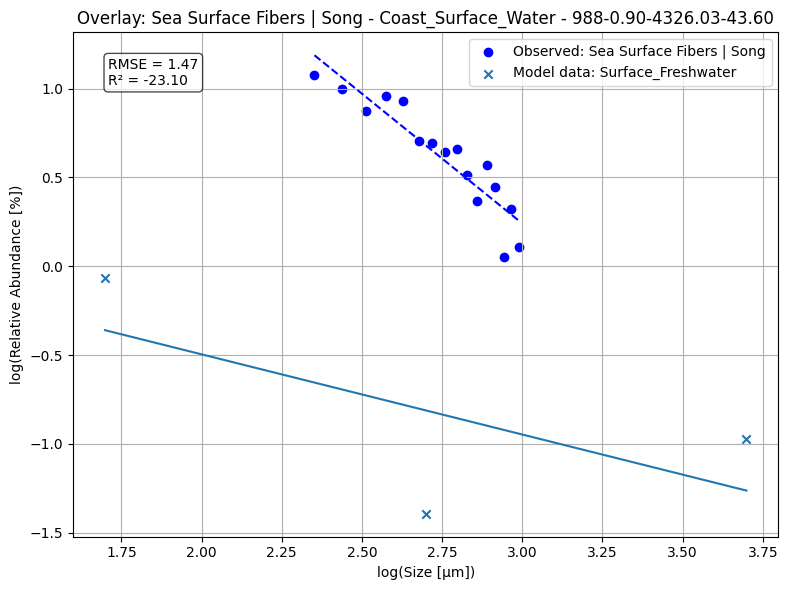

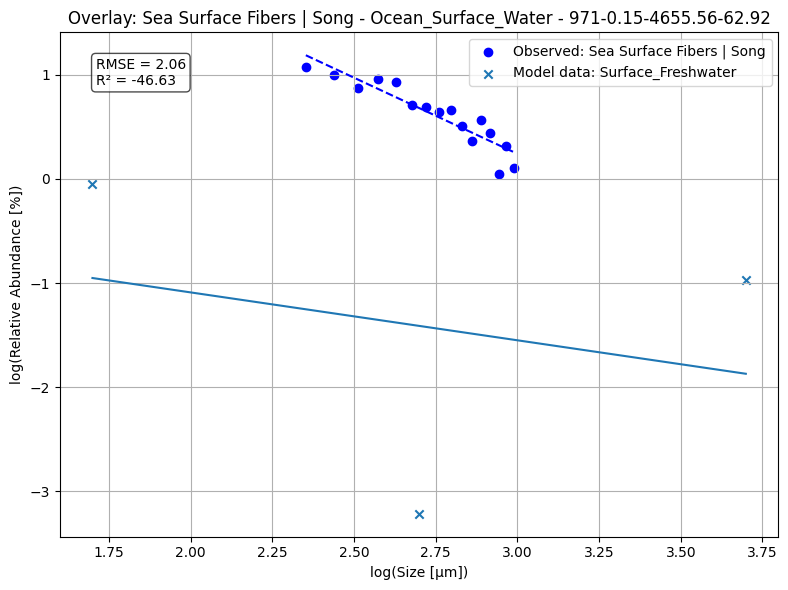

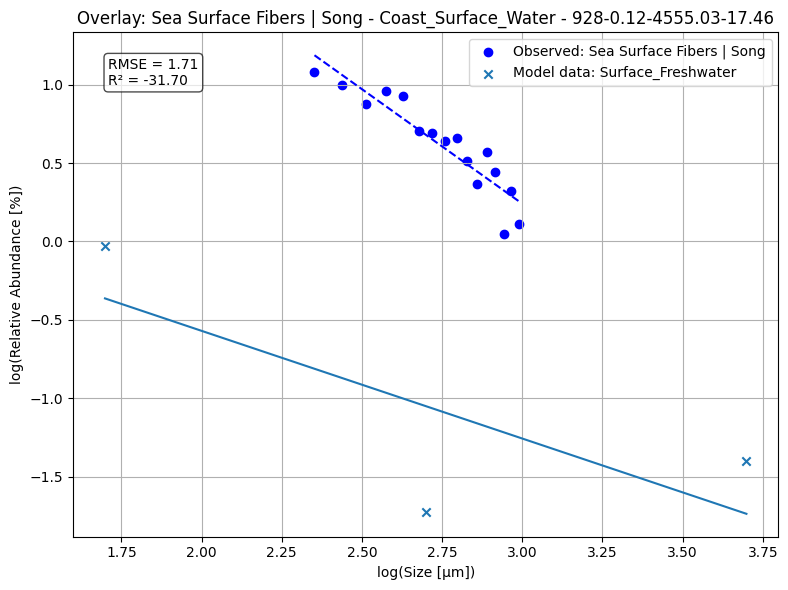

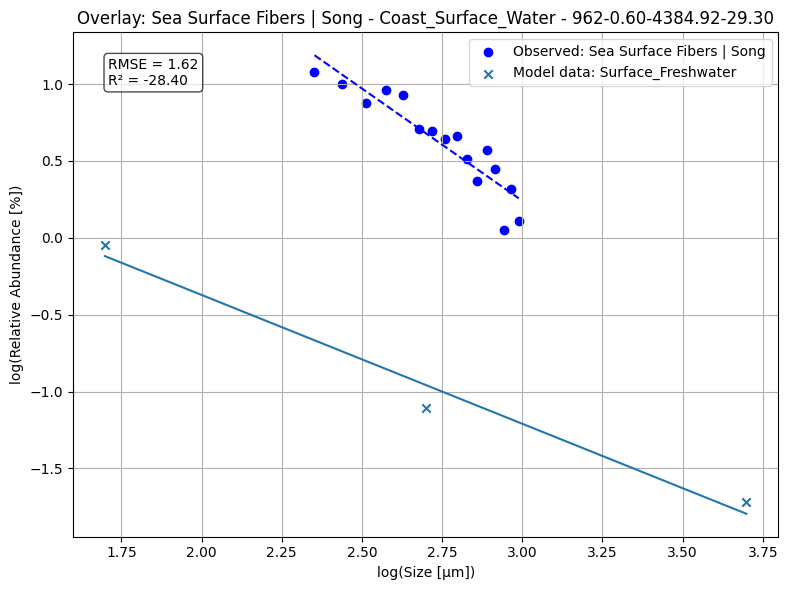

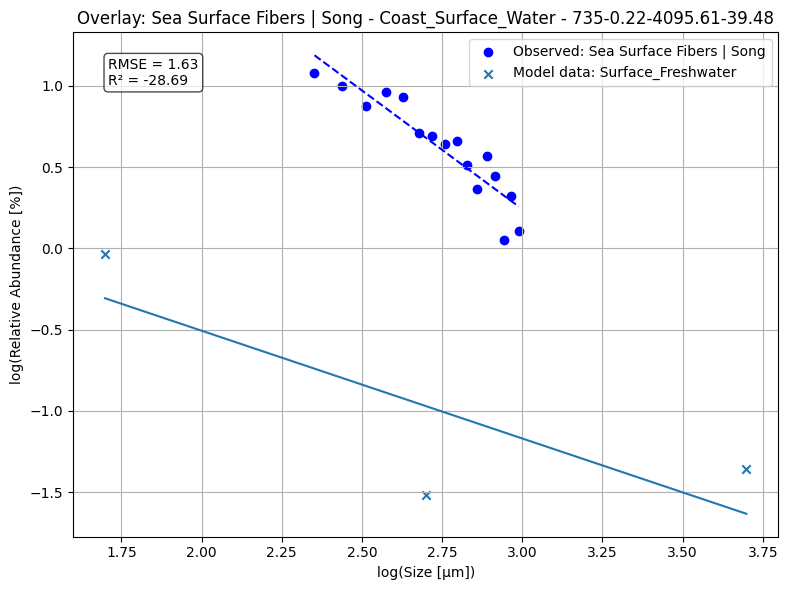

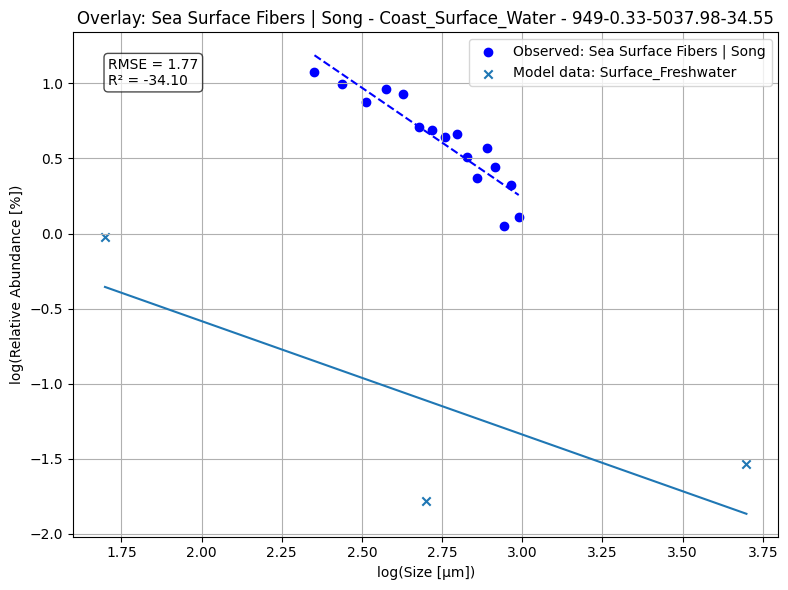

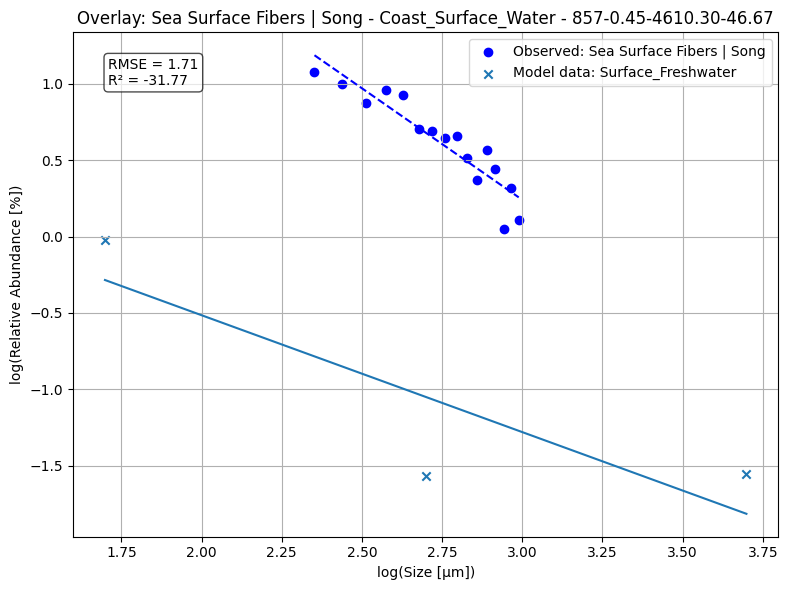

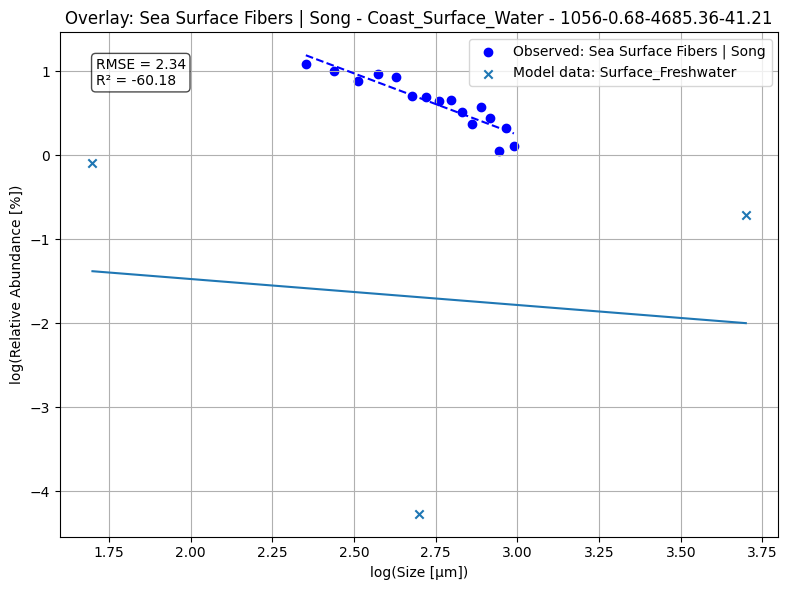

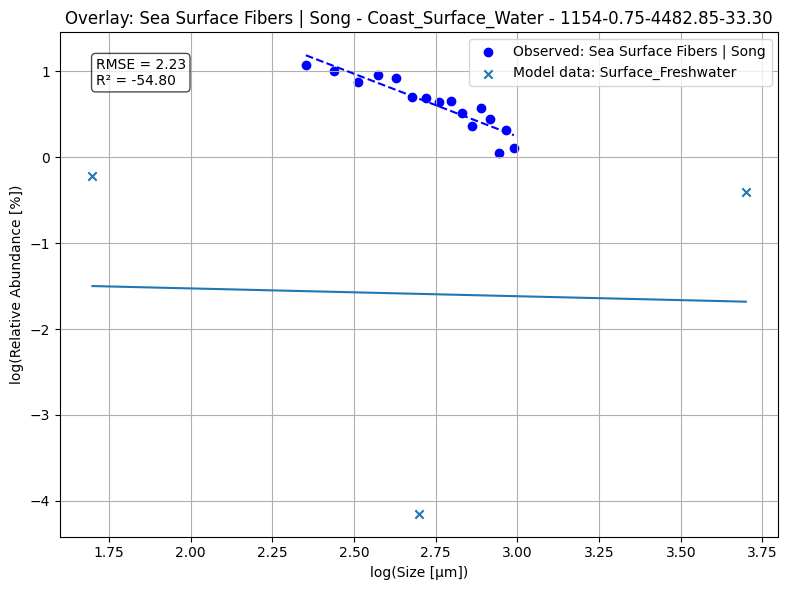

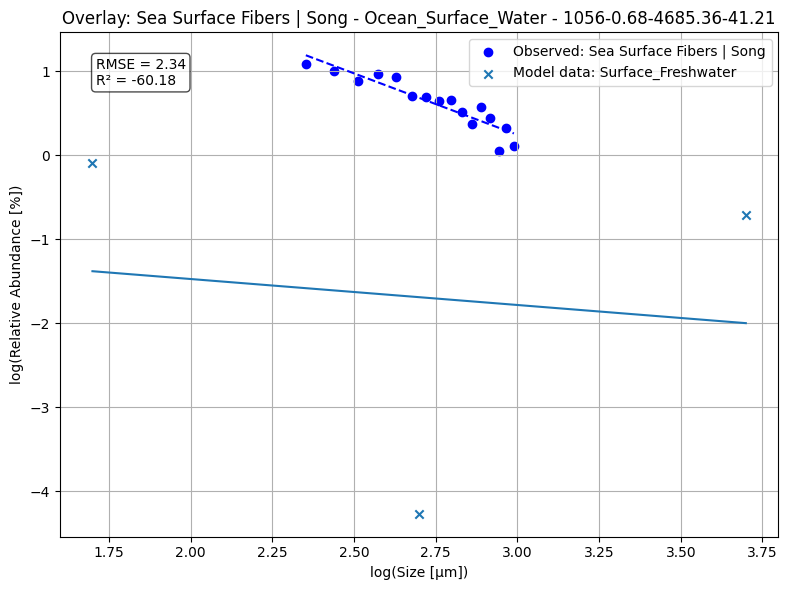

In [18]:
# From top results run model and plot overlays with observed data
run_and_plot_top_results(top_results)